# CARDIOCULATOR

In [1]:
# # pip install --upgrade dask-cudf

# # Install RAPIDS (dask-cudf dependency)
# !pip install -U rapidsai -f https://repo.rapids.ai/nvidia

# # Install dask-cudf
# !pip install dask-cudf


In [1]:
!pip install pycaret

In [2]:
from pycaret.classification import *

Cardiovascular diseases define a group of diseases that affect the heart and blood vessels. This group includes various types of diseases such as heart attack, stroke, heart failure, and arrhythmia. Cardiovascular diseases are among the most common causes of death worldwide and generally emerge due to lifestyle factors (smoking, alcohol, insufficient physical activity, etc.) and genetic predispositions.

According to the World Health Organization's data from 2019, **ischemic heart disease** stands at the forefront of the top 10 diseases causing death today and is held responsible for approximately 16% of deaths. Such a high rate being attributed to a single disease is quite a tragic situation. However, since many risk factors for cardiovascular diseases are preventable, it is essential for individuals and societies to be informed and proactive in reducing these risks.

In this context, a machine learning model that can predict disease risk with cardiovascular medical data could be a significant step for public health. This model can assist individuals in better understanding their health conditions and taking necessary precautions.

**ABOUT DATASET**

The columns and their descriptions of our dataset, which consists of 70,000 observation units, are as follows:

* *id*      -> Unique identifier for each person
* *age*     -> Age (day)   
* *gender*  -> Gender       
* *height*  -> Height (cm)     
* *weight*  -> Weight (kg)    
* *ap_hi*   -> Systolic blood pressure (mm Hg)     
* *ap_lo*   -> Diastolic blood pressure (mm Hg)
* *cholesterol*  -> Cholesterol level in the blood (total)
* *gluc*    -> Blood glucose level        
* *smoke*   -> Smoking status       
* *alco*    -> Alcohol consumption status      
* *active*  -> Physical activity   
* *cardio*  -> Presence/Absence of cardiovascular disease -> **Target**

<a id='section_1'></a>
### Data Introduction and Exploration

In [4]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     -------------------------- ------------- 30.7/47.0 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 471.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.0 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 0.1/101.0 MB 1.4 MB/s eta 0:01:10
   ---------------------------------------- 0.3/101.0 MB 2.0 MB/s eta 0:00:52
   ---------------------------------------- 0.4/101.0 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 0.5/101.0 MB 2.5 MB/s eta 0:00:40
   ---------------------------------------- 0.8/101.0 MB 3.0 MB/s eta 0:00:34
   ----------------

We will start with the necessary library imports and adjustments.

In [3]:
# !pip install termcolor
# !pip install missingno
!pip install xgboost

In [4]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#----------------------------------------------#

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, classification_report, RocCurveDisplay

#----------------------------------------------#

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 300)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [5]:
df_real = pd.read_csv("cardio_train.csv", sep=';')

To protect the original data, provide a fallback in case of errors, and assess the impact of changes, we will create a copy of the dataframe and work on that copy.

In [6]:
df = df_real.copy()

Let's take a look at the dataframe.

In [7]:
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
0   0  18393       2     168  62.000    110     80            1     1      0     0       1       0
1   1  20228       1     156  85.000    140     90            3     1      0     0       1       1
2   2  18857       1     165  64.000    130     70            3     1      0     0       0       1
3   3  17623       2     169  82.000    150    100            1     1      0     0       1       1
4   4  17474       1     156  56.000    100     60            1     1      0     0       0       0

In [8]:
TARGET = "cardio"
# Our target variable is "cardio"

When we look at the dataset, the first thing we notice is that the data in the age variable is based on days. Therefore, we will make corrections first.

In [9]:
df["age"] = df["age"].map(lambda x: x // 365.25)

In [10]:
df["age"].head(10)

0   50.000
1   55.000
2   51.000
3   48.000
4   47.000
5   59.000
6   60.000
7   61.000
8   48.000
9   54.000
Name: age, dtype: float64

In the gender column, the values are currently set to 1 and 2, but to optimize computations for the machine learning model, we will convert them to 0 and 1. To understand which category represents which gender, let's examine the dataset based on gender.

In [11]:
df.groupby("gender").mean()

id    age  height  weight   ap_hi   ap_lo  cholesterol  gluc  smoke  alco  active  cardio
gender                                                                                                 
1      49898.345 52.916 161.356  72.566 128.139  94.523        1.385 1.235  0.018 0.025   0.802   0.497
2      50110.247 52.593 169.948  77.257 130.079 100.552        1.334 1.210  0.219 0.106   0.807   0.505

As seen, the age averages are equal; in this case, we can say that the category with higher averages in height and weight represents males.

In [12]:
df['gender'] = df['gender'].replace({2: "male", 1: "female"})

In [13]:
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
0   0 50.000    male     168  62.000    110     80            1     1      0     0       1       0
1   1 55.000  female     156  85.000    140     90            3     1      0     0       1       1
2   2 51.000  female     165  64.000    130     70            3     1      0     0       0       1
3   3 48.000    male     169  82.000    150    100            1     1      0     0       1       1
4   4 47.000  female     156  56.000    100     60            1     1      0     0       0       0

In [89]:
# # Assuing your DataFrame is named 'df'

# # Identify and handle outliers
# outlier_threshold = 300  # Adjust as needed based on your analysis
# df['ap_hi'] = np.where(df['ap_hi'] > outlier_threshold, np.nan, df['ap_hi'])

# # Replace NaN values with the median
# df['ap_hi'].fillna(df['ap_hi'].median(), inplace=True)

# # Verify data entry errors and correct if necessary
# df['ap_hi'] = np.where(df['ap_hi'] < 0, -df['ap_hi'], df['ap_hi'])

# # Verify valid ranges
# valid_range = (80, 220)  # Adjust based on expected blood pressure ranges
# df['ap_hi'] = np.clip(df['ap_hi'], valid_range[0], valid_range[1])

In [16]:
import pandas as pd
import numpy as np


# Handle outliers in 'ap_hi' and 'ap_lo' using the median
median_hi = df['ap_hi'].median()
median_lo = df['ap_lo'].median()

# Define a threshold multiplier
threshold_multiplier = 1.50

# Identify and handle outliers in 'ap_hi'
df['ap_hi'] = np.where(df['ap_hi'] > median_hi * threshold_multiplier, median_hi, df['ap_hi'])
df['ap_hi'] = np.where(df['ap_hi'] < 0, -df['ap_hi'], df['ap_hi'])

# Identify and handle outliers in 'ap_lo'
df['ap_lo'] = np.where(df['ap_lo'] > median_lo * threshold_multiplier, median_lo, df['ap_lo'])
df['ap_lo'] = np.where(df['ap_lo'] < 0, -df['ap_lo'], df['ap_lo'])

# Verify valid ranges
valid_range_hi = (80, 220)  # Adjust based on expected blood pressure ranges
valid_range_lo = (40, 120)  # Adjust based on expected blood pressure ranges
df['ap_hi'] = np.clip(df['ap_hi'], valid_range_hi[0], valid_range_hi[1])
df['ap_lo'] = np.clip(df['ap_lo'], valid_range_lo[0], valid_range_lo[1])

In [18]:
print(df['ap_hi'].median() * 1.50)

180.0


In [90]:
import pandas as pd
import numpy as np

# # Handle NaN values in 'ap_hi' and 'ap_lo' within the valid range
# valid_range_hi = (80, 220)
# valid_range_lo = (40, 120)
# df['ap_hi'] = np.clip(df['ap_hi'].fillna(df['ap_hi'].median()), valid_range_hi[0], valid_range_hi[1])
# df['ap_lo'] = np.clip(df['ap_lo'].fillna(df['ap_lo'].median()), valid_range_lo[0], valid_range_lo[1])

# # Blood Pressure Category with labels based on both ap_hi and ap_lo
# bins_bp_hi = [-np.inf, 120, 129, 139, 180, np.inf]
# bins_bp_lo = [-np.inf, 80, 89, 120, np.inf]

# labels_bp = ['Normal', 'Elevated', 'High Stage 1', 'High Stage 2', 'Hypertensive Crisis']

# df['blood_pressure_category'] = pd.cut(df[['ap_hi', 'ap_lo']].min(axis=1), bins=[bins_bp_hi[0], *bins_bp_hi[1:]], labels=labels_bp)

# df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

# # Handle NaN values in 'bmi'
# df['bmi'].fillna(df['bmi'].median(), inplace=True)

# # BMI Category with 7 bins (including categories for values less than -np.inf to 18.5 and greater than 34.9 to np.inf)
# bins_bmi = [-np.inf, 18.5, 24.9, 29.9, 34.9, np.inf]
# labels_bmi = [0, 1, 2, 3, 4, 5, 6]

# df['bmi_category'] = pd.cut(df['bmi'], bins=bins_bmi, labels=False)
# df['bmi_category'] = df['bmi_category'].map({i: label for i, label in enumerate(labels_bmi)})
# df['bmi_category'] = df['bmi_category'].astype('Int64')  # Convert to int64

In [92]:
# df.blood_pressure_category.unique()
# df.bmi_category.unique()

<IntegerArray>
[1, 4, 2, 3, 0]
Length: 5, dtype: Int64

Underweight (BMI < 18.5):

Individuals with a BMI below 18.5 are considered underweight. This may indicate insufficient body weight relative to height.
Normal Weight (18.5 ≤ BMI < 24.9):

BMI values between 18.5 and 24.9 are generally considered normal. This range is associated with a healthy weight for most adults.
Overweight (25 ≤ BMI < 29.9):

Individuals with a BMI in this range are considered overweight. This may suggest excess body weight relative to height.
Obese Class I (30 ≤ BMI < 34.9):

This category indicates obesity class I. Obesity is further classified into classes based on BMI, with class I indicating moderate obesity.
Obese Class II (35 ≤ BMI < 39.9):

Individuals with a BMI in this range fall into obesity class II, indicating a higher level of obesity.
Obese Class III (BMI ≥ 40):

_________________
Underweight (BMI < 18.5):

Label: 0
Description: Individuals with a BMI below 18.5 are considered underweight. This may indicate insufficient body weight relative to height.
Normal Weight (18.5 ≤ BMI < 24.9):

Label: 1
Description: BMI values between 18.5 and 24.9 are generally considered normal. This range is associated with a healthy weight for most adults.
Overweight (25 ≤ BMI < 29.9):

Label: 2
Description: Individuals with a BMI in this range are considered overweight. This may suggest excess body weight relative to height.
Obese Class I (30 ≤ BMI < 34.9):

Label: 3
Description: This category indicates obesity class I. Obesity is further classified into classes based on BMI, with class I indicating moderate obesity.
Obese Class II (35 ≤ BMI < 39.9):

Label: 4
Description: Individuals with a BMI in this range fall into obesity class II, indicating a higher level of obesity.

In [19]:
df.head(50)

id    age  gender  height  weight   ap_hi   ap_lo  cholesterol  gluc  smoke  alco  active  cardio
0    0 50.000    male     168  62.000 110.000  80.000            1     1      0     0       1       0
1    1 55.000  female     156  85.000 140.000  90.000            3     1      0     0       1       1
2    2 51.000  female     165  64.000 130.000  70.000            3     1      0     0       0       1
3    3 48.000    male     169  82.000 150.000 100.000            1     1      0     0       1       1
4    4 47.000  female     156  56.000 100.000  60.000            1     1      0     0       0       0
5    8 59.000  female     151  67.000 120.000  80.000            2     2      0     0       0       0
6    9 60.000  female     157  93.000 130.000  80.000            3     1      0     0       1       0
7   12 61.000    male     178  95.000 130.000  90.000            3     3      0     0       1       1
8   13 48.000  female     158  71.000 110.000  70.000            1     1      0     0       1       0
9   14 54.000  female     164  68.000 110.000  60.000            1     1      0     0       0       0
10  15 61.000  female     169  80.000 120.000  80.000            1     1      0     0       1       0
11  16 51.000    male     173  60.000 120.000  80.000            1     1      0     0       1       0
12  18 40.000    male     165  60.000 120.000  80.000            1     1      0     0       0       0
13  21 54.000  female     158  78.000 110.000  70.000            1     1      0     0       1       0
14  23 39.000    male     181  95.000 130.000  90.000            1     1      1     1       1       0
15  24 45.000    male     172 112.000 120.000  80.000            1     1      0     0       0       1
16  25 58.000  female     170  75.000 130.000  70.000            1     1      0     0       0       0
17  27 45.000  female     158  52.000 110.000  70.000            1     3      0     0       1       0
18  28 47.000  female     154  68.000 100.000  70.000            1     1      0     0       0       0
19  29 59.000    male     162  56.000 120.000  70.000            1     1      1     0       1       0
20  30 54.000    male     163  83.000 120.000  80.000            1     1      0     0       1       0
21  31 58.000  female     157  69.000 130.000  80.000            1     1      0     0       1       0
22  32 63.000  female     158  90.000 145.000  85.000            2     2      0     0       1       1
23  33 64.000    male     156  45.000 110.000  60.000            1     1      0     0       1       0
24  35 45.000  female     170  68.000 150.000  90.000            3     1      0     0       1       1
25  36 39.000  female     153  65.000 130.000 100.000            2     1      0     0       1       0
26  37 53.000  female     156  59.000 130.000  90.000            1     1      0     0       1       0
27  38 49.000  female     159  78.000 120.000  80.000            1     1      0     0       1       0
28  39 39.000    male     166  66.000 120.000  80.000            1     1      0     0       1       0
29  40 57.000    male     169  74.000 130.000  70.000            1     3      0     0       0       0
30  42 50.000  female     155 105.000 120.000  80.000            3     1      0     0       1       1
31  43 63.000  female     169  71.000 140.000  90.000            3     1      0     0       1       1
32  44 39.000  female     159  60.000 110.000  70.000            1     1      0     0       1       0
33  45 56.000  female     160  73.000 130.000  85.000            1     1      0     0       0       1
34  46 60.000    male     173  82.000 140.000  90.000            3     1      0     0       0       1
35  47 55.000  female     163  55.000 120.000  80.000            1     1      0     0       1       0
36  49 50.000    male     175  95.000 120.000  80.000            1     1      0     0       1       0
37  51 49.000  female     164  70.000 130.000  90.000            1     1      0     0       1       0
38  52 64.000    male     

In [20]:
def check_df(dataframe):
    print("---------- SHAPE ----------")
    print(dataframe.shape)
    print("---------- TYPES ----------")
    print(dataframe.dtypes)
    print("---------- NA VALUES ----------")
    print(dataframe.isnull().sum())

In [21]:
check_df(df)

---------- SHAPE ----------
(70000, 13)
---------- TYPES ----------
id               int64
age            float64
gender          object
height           int64
weight         float64
ap_hi          float64
ap_lo          float64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object
---------- NA VALUES ----------
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [22]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]


    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

#### About function :

 * It gives the names of categorical, numerical, and categorical but cardinal variables in the data set.

Note: Categorical variables with numerical appearance are also included in categorical variables.

 Parameters :

 ***cat_th*** (int) : Optional threshold value for variables that appear numeric but are categorical

 ***car_th*** (int) : Optional threshold value for categorical but cardinal variables

Note : cat_cols + num_cols + cat_but_car = total number of variables

Note : num_but_cat is inside cat_cols


In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"\n{colored('Numerical Columns:','blue', attrs=['reverse'])} {num_cols}\n\n\n{colored('Categorical Columns:','magenta', attrs=['reverse'])} {cat_cols}\n\n\n"
        f"{colored('Cardinal Columns:','cyan', attrs=['reverse'])}{cat_but_car}\n")

Observations: 70000
Variables: 13
cat_cols: 7
num_cols: 6
cat_but_car: 0
num_but_cat: 6

Numerical Columns: ['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo']


Categorical Columns: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


Cardinal Columns:[]



In [24]:
# For analysis of categorical variables :

def cat_summary(dataframe, col_name, plot=False):
    display(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [25]:

for col in cat_cols:
    cat_summary(df, col)

gender  Ratio
female   45530 65.043
male     24470 34.957

cholesterol  Ratio
1        52385 74.836
2         9549 13.641
3         8066 11.523

gluc  Ratio
1  59479 84.970
3   5331  7.616
2   5190  7.414

smoke  Ratio
0  63831 91.187
1   6169  8.813

alco  Ratio
0  66236 94.623
1   3764  5.377

active  Ratio
1   56261 80.373
0   13739 19.627

cardio  Ratio
0   35021 50.030
1   34979 49.970

* Based on our observations, we can infer that there is an imbalance in the variables related to 'smoking', 'alcohol', and 'activity' in the dataset. Therefore, the values in these variables may not be very reliable for this study.

* One point to note is that the values in the glucose and cholesterol variables in the dataset are categorized as 1, 2, and 3. Based on our domain knowledge, we can say that 1 represents normal values, 2 represents values slightly outside the normal range, and 3 represents values that are considered abnormal.


#### Result----------        A1C Test----------       Fasting Blood Sugar Test

  **Diabetes**-------> 6.5% or above---------    126 mg/dL or above ----- **category 3**
  
  **Prediabetes**---->  5.7% – 6.4%-----------      100 – 125 mg/dL-------- **category 2**
  
  **Normal**--------->       Below 5.7%------------      99 mg/dL or below----- **category 1**
  
  
#### Result ............     Fasting Blood Sugar Test

  **Low** ...........................     <200 mg/dl ------- **category 3**
  
  **Borderline High** .....  200-239 mg/dl --- **category 2**
  
  **High** ............................  >240 mg/dl ------ **category 1**
  
 * In our dataset, it's quite advantageous that the distribution of our target variable is homogeneous. However, we can say that the distribution of the gender variable is not as balanced.

In [26]:
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

In [27]:
# For analysis of numerical variables :

def num_summary(dataframe, numerical_col, plot=False):
    if plot:
        dataframe[numerical_col].hist(bins=200)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

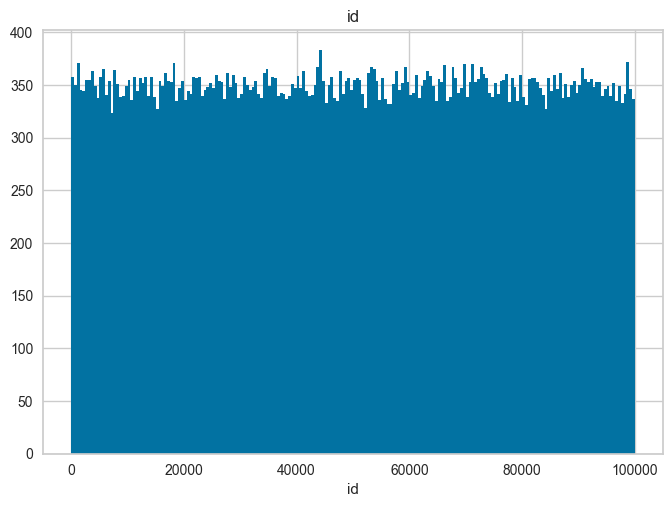

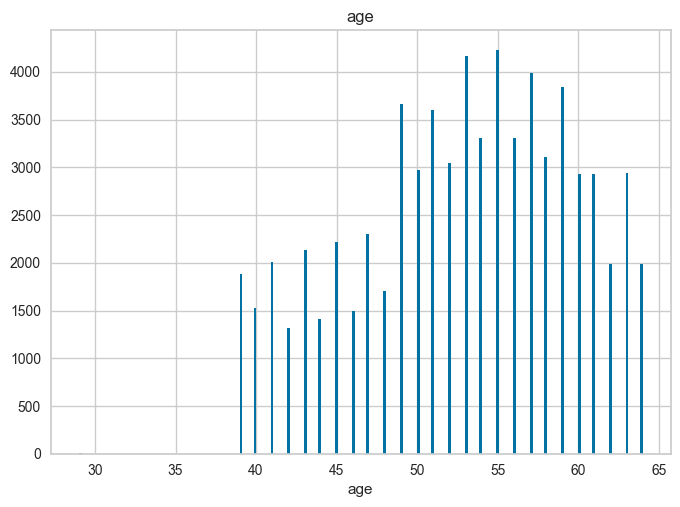

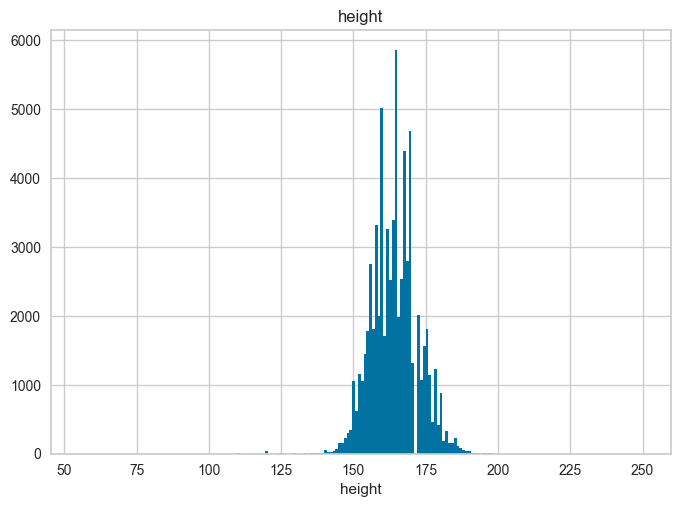

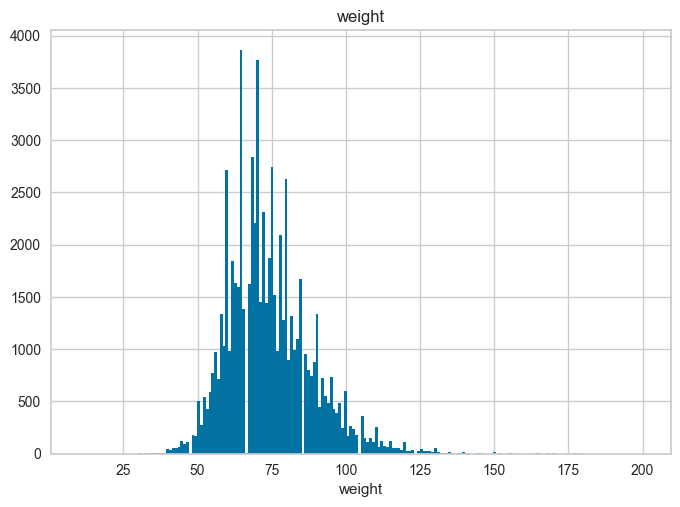

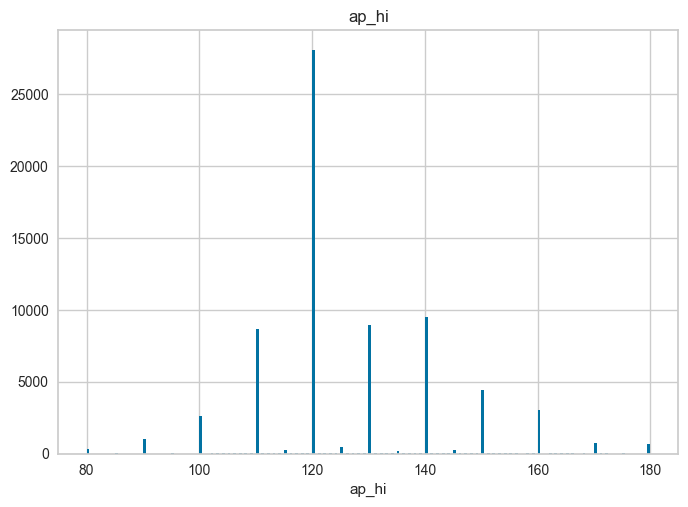

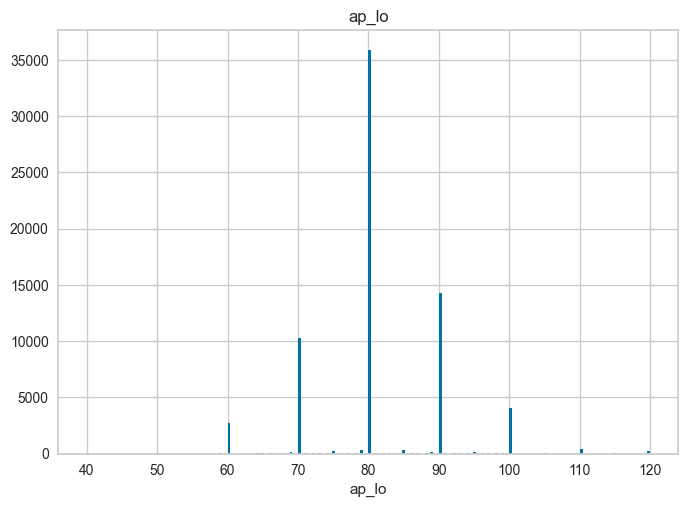

In [28]:
for col in num_cols:
    num_summary(df, col, True)

In [29]:
# Analysis of Categorical Variables on the Target Variable:

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_Mean": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [30]:
for col in cat_cols:
    target_summary_with_cat(df,TARGET,col)

        TARGET_Mean
gender             
0             0.505
1             0.497


             TARGET_Mean
cholesterol             
1                  0.440
2                  0.602
3                  0.765


      TARGET_Mean
gluc             
1           0.481
2           0.593
3           0.622


       TARGET_Mean
smoke             
0            0.502
1            0.475


      TARGET_Mean
alco             
0           0.501
1           0.484


        TARGET_Mean
active             
0             0.536
1             0.491


        TARGET_Mean
cardio             
0             0.000
1             1.000




In [31]:
# Analysis of Numerical Variables on the Target Variable:

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [32]:
for col in num_cols:
    target_summary_with_num(df, TARGET, col)

              id
cardio          
0      49862.869
1      50082.102


          age
cardio       
0      51.195
1      54.413


        height
cardio        
0      164.448
1      164.270


        weight
cardio        
0       71.592
1       76.822


         ap_hi
cardio        
0      119.469
1      133.560


        ap_lo
cardio       
0      78.127
1      84.402




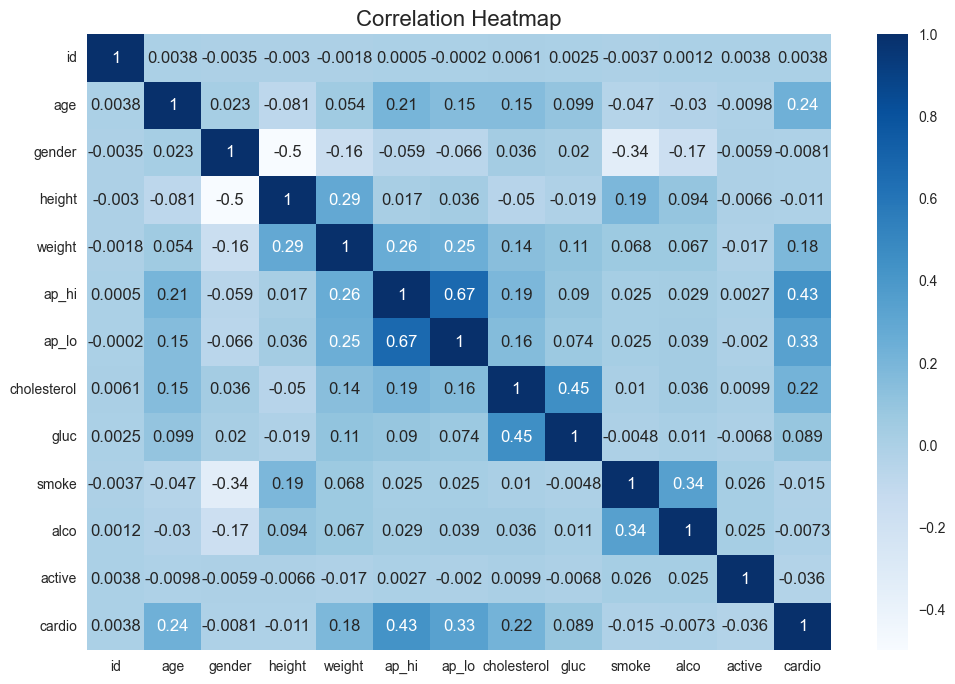

In [33]:
cor = df.corr()
plt.figure(figsize=(12, 8))
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.heatmap(cor, cmap="Blues", annot=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [71]:
# df.drop('bmi_category', axis=1, inplace=True)
# df.head(5)

<a id='section_2'></a>
### Exploratory Data Analysis(EDA) with Pandas-Profiling

In [34]:
!pip install ydata-profiling

In [35]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
df.describe().T

count      mean       std    min       25%       50%       75%       max
id          70000.000 49972.420 28851.302  0.000 25006.750 50001.500 74889.250 99999.000
age         70000.000    52.803     6.762 29.000    48.000    53.000    58.000    64.000
gender      70000.000     0.650     0.477  0.000     0.000     1.000     1.000     1.000
height      70000.000   164.359     8.210 55.000   159.000   165.000   170.000   250.000
weight      70000.000    74.206    14.396 10.000    65.000    72.000    82.000   200.000
ap_hi       70000.000   126.510    16.501 80.000   120.000   120.000   140.000   180.000
ap_lo       70000.000    81.263     9.432 40.000    80.000    80.000    90.000   120.000
cholesterol 70000.000     1.367     0.680  1.000     1.000     1.000     2.000     3.000
gluc        70000.000     1.226     0.572  1.000     1.000     1.000     1.000     3.000
smoke       70000.000     0.088     0.283  0.000     0.000     0.000     0.000     1.000
alco        70000.000     0.054     0.226  0.000     0.000     0.000     0.000     1.000
active      70000.000     0.804     0.397  0.000     1.000     1.000     1.000     1.000
cardio      70000.000     0.500     0.500  0.000     0.000     0.000     1.000     1.000

Based on the statistical information above, we can say that there are some imbalances and outliers in the dataset. From this point on, medical domain knowledge will be used to make adjustments to the values in the dataset.

<a id='section_3'></a>
### Feature Engineering for Outliers

In [37]:
df[df["ap_hi"]<0]

Empty DataFrame
Columns: [id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

Blood pressure values can never be negative. When we look at the values, we see that they are numerically correct, but due to the negative signs in front of them, they become outliers; therefore, these values will be converted to positive.

In [38]:
df["ap_hi"]=df["ap_hi"].abs()

In [39]:
df[df["ap_lo"]<0]

Empty DataFrame
Columns: [id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

In [40]:
df["ap_lo"]=df["ap_lo"].abs()

In [41]:
df[df["ap_hi"]<25].head()

Empty DataFrame
Columns: [id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

Blood pressure values are expressed in mm Hg during medical evaluations, so they are typically represented as 120/80 rather than 12/8. Considering this, I have observed that systolic blood pressure values in the dataset can be found as less than 25 when they are actually below 250 mm Hg. Hence, I've decided to standardize these values.

In [42]:
df['ap_hi'] = df['ap_hi'].apply(lambda x: x*10 if x < 25 else x)

In [43]:
df[df["ap_hi"]<25].head()

Empty DataFrame
Columns: [id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

After correcting the values and checking again, we find that in 2 observation units, the systolic blood pressure value remains at 10 mm Hg. At this point, I believe it's more appropriate to remove these observation units.

In [44]:
df.drop(df[df["ap_hi"]<25].index, inplace = True)

In [45]:
df[df["ap_lo"]<15].head()

Empty DataFrame
Columns: [id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

We will perform the same procedures for the diastolic blood pressure as well.

In [46]:
df['ap_lo'] = df['ap_lo'].apply(lambda x: x*10 if x < 15 else x)

In [47]:
df[df["ap_lo"]<15]

Empty DataFrame
Columns: [id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

We will also delete the observations with a diastolic blood pressure value of 0.

In [48]:
df.drop(df[df["ap_lo"]<15].index, inplace = True)

Now, for these two blood pressure values, I will set a lower and upper threshold based on my domain knowledge. I will delete the observations that have values below and above these thresholds. For systolic blood pressure, these values will be 80 and 250, and for diastolic blood pressure, these values will be 50 and 150. The adjustments according to this are as follows.

In [49]:
df.drop(df[df["ap_lo"]<50].index, inplace = True)

In [50]:
df.drop(df[df['ap_lo'] > 150].index, inplace = True)

In [51]:
df.drop(df[df['ap_hi'] > 250].index, inplace = True)

In [52]:
df.drop(df[df['ap_hi'] < 80].index, inplace = True)

Technically, systolic blood pressure should always be higher than diastolic blood pressure; any records indicating otherwise in the dataset are likely errors, for these observation units, a conversion will be made between systolic and diastolic blood pressure values.

In [53]:
df[df["ap_hi"]<df["ap_lo"]].head()

id    age  gender  height  weight  ap_hi   ap_lo  cholesterol  gluc  smoke  alco  active  cardio
567    815 58.000       1     168  78.000 80.000  90.000            2     1      0     0       1       1
636    913 56.000       0     169  68.000 80.000 110.000            1     1      0     0       1       0
927   1294 59.000       0     175  70.000 80.000  90.000            3     1      0     0       1       1
2853  4017 62.000       1     156  87.000 80.000  90.000            1     1      0     0       0       1
3447  4880 54.000       0     180  80.000 80.000 120.000            3     3      1     1       1       1

In [54]:
condition = df["ap_hi"]<df["ap_lo"]
df.loc[condition, ["ap_hi", "ap_lo"]] = df.loc[condition, ["ap_lo", "ap_hi"]].values

After this stage, we will examine the values in other variables and make changes. For now, it seems our adjustments related to blood pressure values are complete.

In [55]:
df[df["ap_hi"]==df["ap_lo"]].head()

id    age  gender  height  weight   ap_hi   ap_lo  cholesterol  gluc  smoke  alco  active  cardio
979   1360 49.000       1     172  65.000  80.000  80.000            1     3      0     0       1       0
1328  1863 57.000       0     174 106.000 120.000 120.000            3     3      0     0       1       0
1600  2260 52.000       1     165  66.000  80.000  80.000            1     1      0     0       1       0
1627  2301 61.000       1     165  71.000  80.000  80.000            1     1      0     0       1       1
2167  3057 60.000       0     169  75.000  80.000  80.000            2     1      0     0       1       1

In [56]:
df.drop(df[df["ap_hi"]==df["ap_lo"]].index, inplace = True)

In [57]:
df.describe().T

count      mean       std    min       25%       50%       75%       max
id          69756.000 49974.302 28851.435  0.000 25002.750 50004.500 74894.500 99999.000
age         69756.000    52.803     6.762 29.000    48.000    53.000    58.000    64.000
gender      69756.000     0.650     0.477  0.000     0.000     1.000     1.000     1.000
height      69756.000   164.363     8.190 55.000   159.000   165.000   170.000   250.000
weight      69756.000    74.200    14.382 10.000    65.000    72.000    82.000   200.000
ap_hi       69756.000   126.632    16.338 80.000   120.000   120.000   140.000   180.000
ap_lo       69756.000    81.238     9.210 50.000    80.000    80.000    90.000   120.000
cholesterol 69756.000     1.367     0.680  1.000     1.000     1.000     2.000     3.000
gluc        69756.000     1.226     0.572  1.000     1.000     1.000     1.000     3.000
smoke       69756.000     0.088     0.284  0.000     0.000     0.000     0.000     1.000
alco        69756.000     0.054     0.226  0.000     0.000     0.000     0.000     1.000
active      69756.000     0.804     0.397  0.000     1.000     1.000     1.000     1.000
cardio      69756.000     0.500     0.500  0.000     0.000     0.000     1.000     1.000

In [58]:
df[df["height"]<140].head()

id    age  gender  height  weight   ap_hi   ap_lo  cholesterol  gluc  smoke  alco  active  cardio
224    309 59.000       0      76  55.000 120.000  80.000            1     1      0     0       1       0
2412  3399 61.000       0     138  52.000 140.000 100.000            1     1      0     0       1       1
2944  4150 53.000       1     134  52.000 120.000  70.000            1     1      0     0       0       0
3208  4523 50.000       1     136  57.000 120.000  80.000            1     1      0     0       1       0
3420  4838 39.000       1     100  70.000 100.000  70.000            1     1      0     0       1       0

In [59]:
df.drop(df[df['height'] < 140].index, inplace = True)

In [60]:
df[df["weight"]<35].head()

id    age  gender  height  weight   ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
14722  21040 62.000       1     143  34.000 100.000 70.000            1     1      0     0       1       0
16906  24167 47.000       0     170  31.000 150.000 90.000            2     2      0     0       1       1
18559  26503 49.000       1     160  30.000 120.000 80.000            1     1      0     0       1       1
22016  31439 42.000       1     146  32.000 100.000 70.000            1     1      0     0       0       0
26806  38312 63.000       1     157  23.000 110.000 80.000            1     1      0     0       1       0

In [61]:
df.drop(df[df['weight'] < 35].index, inplace = True)

In [62]:
df.drop(df[df['weight'] > 150].index, inplace = True)

In [63]:
df.drop(df[df['height'] >210].index, inplace = True)

In [64]:
#Let's convert the "weight" variable to an integer type.
df["weight"]=df["weight"].astype(int)

In [65]:
df.describe().T

count      mean       std     min       25%       50%       75%       max
id          69542.000 49975.783 28851.401   0.000 25010.500 50007.500 74891.750 99999.000
age         69542.000    52.804     6.760  29.000    48.000    53.000    58.000    64.000
gender      69542.000     0.650     0.477   0.000     0.000     1.000     1.000     1.000
height      69542.000   164.462     7.807 140.000   159.000   165.000   170.000   207.000
weight      69542.000    74.143    14.114  35.000    65.000    72.000    82.000   150.000
ap_hi       69542.000   126.631    16.331  80.000   120.000   120.000   140.000   180.000
ap_lo       69542.000    81.239     9.206  50.000    80.000    80.000    90.000   120.000
cholesterol 69542.000     1.367     0.680   1.000     1.000     1.000     2.000     3.000
gluc        69542.000     1.226     0.572   1.000     1.000     1.000     1.000     3.000
smoke       69542.000     0.088     0.284   0.000     0.000     0.000     0.000     1.000
alco        69542.000     0.054     0.226   0.000     0.000     0.000     0.000     1.000
active      69542.000     0.804     0.397   0.000     1.000     1.000     1.000     1.000
cardio      69542.000     0.500     0.500   0.000     0.000     0.000     1.000     1.000

When we take a rough look at the min-max, standard deviation values, and averages, we can say that the values we have are currently balanced.

At this point, using the parameters we have, we will generate features for body mass index, body mass index classification, blood pressure value classification, and pulse pressure.

<a id='section_4'></a>
### Feature Extraction

In [66]:
df["bmi"] = df["weight"] *10000 / ((df["height"])**2)

In [67]:
conditions = [
    (df["bmi"] <= 15),                            # 0 - Anorexic
    (df["bmi"] > 15) & (df["bmi"] <= 18.5),       # 1 - Underweight
    (df["bmi"] > 18.5) & (df["bmi"] <= 25),       # 2 - Normal weight
    (df["bmi"] > 25) & (df["bmi"] <= 30),         # 3 - Overweight
    (df["bmi"] > 30) & (df["bmi"] <= 35),         # 4 - Obesity Class I
    (df["bmi"] > 35) & (df["bmi"] <= 40),         # 5 - Obesity Class II
    (df["bmi"] > 40)                              # 6 - Obesity Class III
]

bmi_class = [0, 1, 2, 3, 4, 5, 6]

df["bmi_class"] = np.select(conditions, bmi_class)

In [68]:
def categorize_blood_pressure(dataframe):
    systolic = dataframe['ap_hi']
    diastolic = dataframe['ap_lo']

    if systolic < 120 and diastolic < 80:
        return 0
    elif systolic < 130 and diastolic < 85:
        return 1
    elif (systolic >= 130 and systolic <= 139) or (diastolic >= 85 and diastolic <= 89):
        return 2
    elif (systolic >= 140 and systolic <= 159) or (diastolic >= 90 and diastolic <= 99):
        return 3
    elif (systolic >= 160 and systolic <= 179) or (diastolic >= 100 and diastolic <= 109):
        return 4
    elif systolic >= 180 or diastolic >= 110:
        return 5
    elif systolic >= 140 and systolic <= 160 and diastolic < 90:
        return 6
    elif systolic > 160 and diastolic < 90:
        return 7
    else:
        return -1  #This section is for observations that don't meet any conditions - perhaps for error checking or review.

df['bp_cat'] = df.apply(categorize_blood_pressure, axis=1)

In [69]:
df["pulse_press"] = df["ap_hi"] - df["ap_lo"]

In [70]:
df.head()

id    age  gender  height  weight   ap_hi   ap_lo  cholesterol  gluc  smoke  alco  active  cardio    bmi  bmi_class  bp_cat  pulse_press
0   0 50.000       0     168      62 110.000  80.000            1     1      0     0       1       0 21.967          2       1       30.000
1   1 55.000       1     156      85 140.000  90.000            3     1      0     0       1       1 34.928          4       3       50.000
2   2 51.000       1     165      64 130.000  70.000            3     1      0     0       0       1 23.508          2       2       60.000
3   3 48.000       0     169      82 150.000 100.000            1     1      0     0       1       1 28.710          3       3       50.000
4   4 47.000       1     156      56 100.000  60.000            1     1      0     0       0       0 23.011          2       0       40.000

In [71]:
df.describe().T

count      mean       std     min       25%       50%       75%       max
id          69542.000 49975.783 28851.401   0.000 25010.500 50007.500 74891.750 99999.000
age         69542.000    52.804     6.760  29.000    48.000    53.000    58.000    64.000
gender      69542.000     0.650     0.477   0.000     0.000     1.000     1.000     1.000
height      69542.000   164.462     7.807 140.000   159.000   165.000   170.000   207.000
weight      69542.000    74.143    14.114  35.000    65.000    72.000    82.000   150.000
ap_hi       69542.000   126.631    16.331  80.000   120.000   120.000   140.000   180.000
ap_lo       69542.000    81.239     9.206  50.000    80.000    80.000    90.000   120.000
cholesterol 69542.000     1.367     0.680   1.000     1.000     1.000     2.000     3.000
gluc        69542.000     1.226     0.572   1.000     1.000     1.000     1.000     3.000
smoke       69542.000     0.088     0.284   0.000     0.000     0.000     0.000     1.000
alco        69542.000     0.054     0.226   0.000     0.000     0.000     0.000     1.000
active      69542.000     0.804     0.397   0.000     1.000     1.000     1.000     1.000
cardio      69542.000     0.500     0.500   0.000     0.000     0.000     1.000     1.000
bmi         69542.000    27.446     5.144  12.254    23.875    26.366    30.119    63.975
bmi_class   69542.000     2.986     1.026   0.000     2.000     3.000     4.000     6.000
bp_cat      69542.000     1.640     1.145   0.000     1.000     1.000     3.000     5.000
pulse_press 69542.000    45.391    11.832   2.000    40.000    40.000    50.000   120.000

It is essential to perform data analysis and adjustments for the features we have generated based on our domain knowledge.

In [72]:
df.drop(df[df['bmi'] < 16].index, inplace = True)

In [73]:
df.drop(df[df['bmi'] > 45].index, inplace = True)

In [74]:
df.describe().T

count      mean       std     min       25%       50%       75%       max
id          69047.000 49979.096 28852.665   0.000 25012.500 50009.000 74899.500 99999.000
age         69047.000    52.800     6.763  29.000    48.000    53.000    58.000    64.000
gender      69047.000     0.649     0.477   0.000     0.000     1.000     1.000     1.000
height      69047.000   164.496     7.793 140.000   159.000   165.000   170.000   207.000
weight      69047.000    73.846    13.552  36.000    65.000    72.000    82.000   149.000
ap_hi       69047.000   126.559    16.281  80.000   120.000   120.000   140.000   180.000
ap_lo       69047.000    81.207     9.182  50.000    80.000    80.000    90.000   120.000
cholesterol 69047.000     1.365     0.679   1.000     1.000     1.000     2.000     3.000
gluc        69047.000     1.224     0.570   1.000     1.000     1.000     1.000     3.000
smoke       69047.000     0.088     0.284   0.000     0.000     0.000     0.000     1.000
alco        69047.000     0.054     0.226   0.000     0.000     0.000     0.000     1.000
active      69047.000     0.804     0.397   0.000     1.000     1.000     1.000     1.000
cardio      69047.000     0.498     0.500   0.000     0.000     0.000     1.000     1.000
bmi         69047.000    27.315     4.854  16.004    23.875    26.298    30.104    44.997
bmi_class   69047.000     2.968     0.998   1.000     2.000     3.000     4.000     6.000
bp_cat      69047.000     1.635     1.142   0.000     1.000     1.000     3.000     5.000
pulse_press 69047.000    45.352    11.799   2.000    40.000    40.000    50.000   120.000

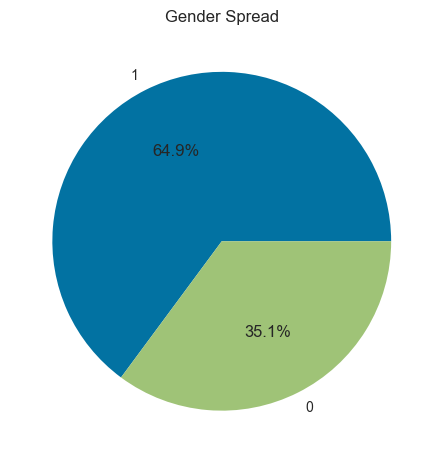

In [75]:

gender_spread = df['gender'].value_counts()
gender_spread.plot.pie(autopct='%1.1f%%')
plt.title("Gender Spread")
plt.ylabel('')
plt.show()

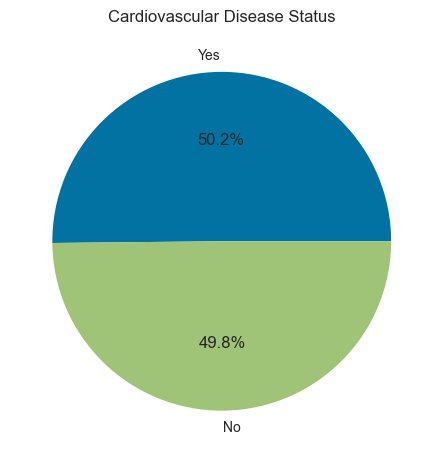

In [76]:
disease_status = df['cardio'].value_counts()
disease_status.plot.pie(autopct='%1.1f%%', labels=['Yes', 'No'])
plt.title("Cardiovascular Disease Status")
plt.ylabel('')
plt.show()

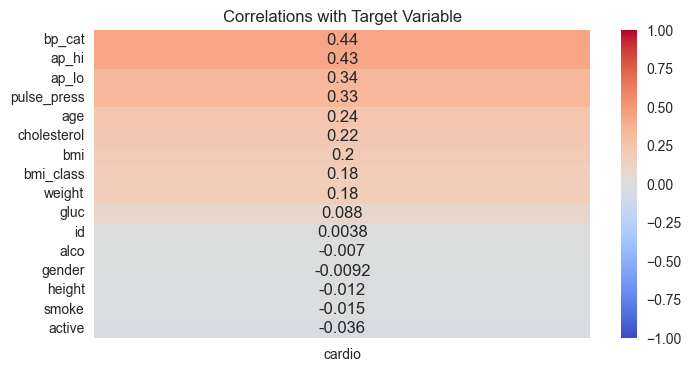

In [77]:
correlation_matrix = df.corr()

#We only take the correlations with 'target'.
target_correlation = correlation_matrix[TARGET].sort_values(ascending=False)
target_correlation = target_correlation.drop("cardio")

plt.figure(figsize=(8, 4))
sns.heatmap(target_correlation.to_frame(), cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.title("Correlations with Target Variable")
plt.show()

In [80]:
# Drop weight and ap_low, as both show high correlation with each other, collinearity .and bp_cat is fine.

columns_to_drop = ['bp_cat', 'ap_lo', 'weight']

# Drop the specified columns
df = df.drop(columns=columns_to_drop, axis=1)

KeyError: 'bp_cat'

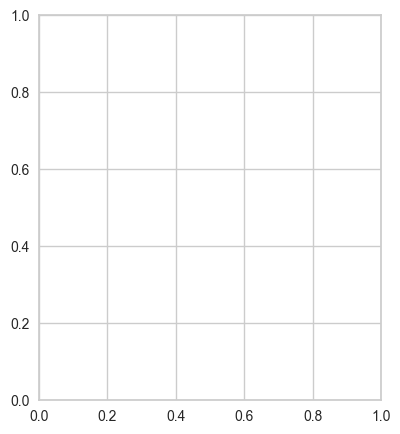

In [81]:
# Working Code:
    
# # Creating figure for histogram
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 1) #In a 1-row x 3-column space, the first plot.
# df['bp_cat'].hist(edgecolor='black')
# plt.title('Distribution of Blood Pressure Values')
# plt.xlabel('Blood Pressure Values')
# plt.ylabel('Frequency')

# plt.subplot(1, 3, 3)
# df['age'].hist(edgecolor='black')
# plt.title('Distribution of Age')
# plt.xlabel('Age')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

<a id='section_5'></a>
### Machine Learning Model

In [82]:
y = df[TARGET]
X = df.drop(columns=['id', TARGET], axis = 1)

In [ ]:
# !pip install pycaret

In [ ]:
# pip install --upgrade pandas

In [ ]:
# pip install --upgrade dask-cudf

In [85]:
# Assuming df is your dataframe
df.to_csv('my_data1.csv', index=False)

In [2]:
# # Accessing output file
import pandas as pd

# Load the data
# df = pd.read_csv('/kaggle/working/my_data.csv')
df = pd.read_csv('my_data.csv')

In [3]:
TARGET = 'cardio'
y = df[TARGET]
X = df.drop(columns=['id', TARGET], axis = 1)

In [4]:
df.head()

id   age  gender  height  ap_hi  cholesterol  gluc  smoke  alco  active  \
0   0  50.0       0     168  110.0            1     1      0     0       1   
1   1  55.0       1     156  140.0            3     1      0     0       1   
2   2  51.0       1     165  130.0            3     1      0     0       0   
3   3  48.0       0     169  150.0            1     1      0     0       1   
4   4  47.0       1     156  100.0            1     1      0     0       0   

   cardio        bmi  bmi_class  pulse_press  
0       0  21.967120          2         30.0  
1       1  34.927679          4         50.0  
2       1  23.507805          2         60.0  
3       1  28.710479          3         50.0  
4       0  23.011177          2         40.0

In [89]:
# X.head()
y.head()

0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

In [90]:
from pycaret.classification import *
s = setup(df, target = 'cardio', train_size = 0.8, ignore_features = 'id', fold = 3)

In [91]:
best = compare_models()

* As seen above, with pycaret, we've seen which model objects might be successful for this project. Despite very minor differences in success rates, LightGBM works much faster, so we will use light gbm here.

In [ ]:
# !pip install lightgbm

In [ ]:
# lgbm_model = LGBMClassifier()

In [ ]:
# lgbm_model.get_params()

In [ ]:
# lgbm_model_= cross_validate(lgbm_model, X, y, cv = 10, scoring = ["accuracy", "f1", "roc_auc"])

In [ ]:
# lgbm_model_["test_accuracy"].mean()

In [ ]:
# lgbm_model_["test_f1"].mean()

In [ ]:
# lgbm_model_["test_roc_auc"].mean()

     As can be seen, the success metrics of the base model established with LightGBM can be said to be quite good. Now, to achieve a slight increase in model performance, we will perform hyperparameter optimization.

<a id='section_6'></a>
### Hyperparameter Optimization with Grid Search CV

In [ ]:
# params = {'colsample_bytree': [0.55,0.65,0.70,1],
#          'min_child_samples':[12,15,20],
#          'max_depth':[-1,3,7],
# #          'learning_rate':[0.1,0.5,1]}

In [ ]:
# lgbm_best = GridSearchCV(lgbm_model,
#                              params,
#                              cv = 5,
#                              n_jobs = -1,
#                              verbose = True).fit(X, y)

In [ ]:
# lgbm_best.best_score_

In [ ]:
# lgbm_best.best_params_

<a id='section_7'></a>
### Final Model

In [ ]:
# final_model = lgbm_model.set_params(**lgbm_best.best_params_).fit(X, y)

In [ ]:
# cv_results_last = cross_validate(final_model,
#                            X,
#                            y,
#                            cv = 5,
#                            scoring = ["accuracy", "f1", "roc_auc"])

In [ ]:
# cv_results_last['test_accuracy'].mean()

In [ ]:
# cv_results_last['test_f1'].mean()

In [ ]:
# cv_results_last['test_roc_auc'].mean()

In [ ]:
# accuracy = cv_results_last['test_accuracy'].mean()
# f1_score = cv_results_last['test_f1'].mean()
# roc_auc = cv_results_last['test_roc_auc'].mean()


# data = {
#     'Metric': ['Accuracy', 'F1', 'ROC AUC'],
#     'Value': [accuracy, f1_score, roc_auc]
# }
# dfii = pd.DataFrame(data)

# plt.figure(figsize=(8, 5))
# ax = sns.barplot(x='Metric', y='Value', data=dfii, palette="viridis")

# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.4f'),
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 10),
#                 textcoords = 'offset points')

# plt.ylim(0, 1.1)

If we want to observe which variable the model learned more from during training:

In [ ]:
# import lightgbm as lgb
# lgb.plot_importance(final_model, importance_type='split', max_num_features=6, figsize=(10, 6))
# plt.title("Features Used to Train Model.")
# plt.show()

 Let's randomly select an observation unit from our dataset and have our model make a prediction.

In [ ]:
# random_user = X.sample(1)
# final_model.predict(random_user)

In [94]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset (replace 'your_dataset.csv' with your actual file)
data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Number of features you want to select
num_features = 12  # Adjust as needed

# Technique: Recursive Feature Elimination (RFE)
model = RandomForestClassifier()  # You can use any model here
rfe = RFE(model, n_features_to_select=num_features)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Example: Train a model using the selected features and evaluate
model_selected = RandomForestClassifier(random_state=42)
model_selected.fit(X_train_rfe, y_train)
y_pred = model_selected.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with {num_features} selected features using RFE: {accuracy}")


Accuracy with 12 selected features using RFE: 0.7080376538740043


Our prediction model is ready. If we want to use our model on different computers after this stage, we can save our model as a file using joblib.
#### Thanks to machine learning, we have gained a different perspective on preventive medicine in the medical sector. If you have any questions, comments, or feedback, please feel free to share and **do not forget to take care your heart and yourself**

<center><img src="https://media.giphy.com/media/j2xsmlsdig4PWE7GgA/giphy.gif" width="500"/></center>

In [ ]:
## Update

In [7]:
# Import necessary libraries
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [8]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Load your dataset and split it into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define base models for bagging
base_model1 = DecisionTreeClassifier()
base_model2 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

In [10]:
# Create a Bagging ensemble
bagging_ensemble = BaggingClassifier(base_model1, n_estimators=10, random_state=42)

In [11]:
# Define the stacking ensemble with a neural network as the final estimator
stacking_ensemble = StackingClassifier(
    estimators=[('bagging', bagging_ensemble), ('mlp', base_model2)],
    final_estimator=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    stack_method='auto',
)

In [12]:
# Cross-validate the stacking ensemble
cv_results = cross_validate(stacking_ensemble, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

Cross-validated results:
Accuracy: 0.7115297222018617
F1-score: 0.7303597418760969
ROC AUC: 0.7955526639438518


In [13]:
# Train the stacking ensemble on the entire dataset
stacking_ensemble.fit(X, y)

StackingClassifier(estimators=[('bagging',
                                BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                  random_state=42)),
                               ('mlp',
                                MLPClassifier(max_iter=500, random_state=42))],
                   final_estimator=MLPClassifier(max_iter=500, random_state=42))

In [14]:
# Make predictions on the test set
predictions = stacking_ensemble.predict(X_test)

# Evaluate the accuracy of the stacking ensemble with a neural network
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the stacking ensemble with a neural network: {accuracy}")

Accuracy of the stacking ensemble with a neural network: 0.7037308509858535


### Another Model 2

In [5]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Load your dataset and split it into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your base models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(probability=True, random_state=42)
model4 = GradientBoostingClassifier(n_estimators=100, random_state=42)  # Replace LGBM with Gradient Boosting

In [7]:
# Create an ensemble of models using a more advanced technique like stacking
# Stacking combines the predictions of multiple base estimators to improve accuracy
ensemble_model = VotingClassifier(estimators=[
    ('rf', model1),
    ('lr', model2),
    ('svc', model3),
    ('gb', model4)  # Add Gradient Boosting
], voting='soft')  # 'soft' enables probability voting for SVC

In [ ]:
# Cross-validate the ensemble model
cv_results = cross_validate(ensemble_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

In [ ]:
# Hyperparameter optimization using GridSearchCV
params = {
    'rf__n_estimators': [50, 100, 150],
    'svc__C': [1, 10, 100],
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=ensemble_model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

In [ ]:
grid_search.fit(X, y)

In [ ]:
# Display best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Fit the ensemble model on the entire dataset with the best parameters
best_ensemble_model = grid_search.best_estimator_

In [ ]:
best_ensemble_model.fit(X, y)

In [ ]:
# Evaluate the best ensemble model on the entire dataset
best_ensemble_predictions = best_ensemble_model.predict(X_test)

In [ ]:
# Accuracy
best_accuracy = accuracy_score(y_test, best_ensemble_predictions)
print(f"Best Ensemble Model Accuracy: {best_accuracy}")

# Precision, Recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, best_ensemble_predictions)
recall = recall_score(y_test, best_ensemble_predictions)
f1 = f1_score(y_test, best_ensemble_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

### Another model 15/11/2023

In [71]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset and split it into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your base models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10, random_state=42)
model3 = XGBClassifier(random_state=42)
model4 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

In [72]:
# Define the stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[('rf', model1), ('bagging', model2), ('xgb', model3), ('mlp', model4)],
    final_estimator=LogisticRegression(),  # You can choose another final estimator based on your needs
    stack_method='auto',
)

In [73]:
# Fit the stacking ensemble on your training data
stacking_ensemble.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('bagging',
                                BaggingClassifier(base_estimator=RandomForestClassifier(),
                                                  random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categor...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('mlp',
                                MLPClassifier(max_iter=500, random_state=42))],
                   final_estimator=LogisticRegression())

In [74]:
# Make predictions on the test set
predictions = stacking_ensemble.predict(X_test)

# Evaluate the accuracy of the stacking ensemble
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the stacking ensemble: {accuracy}")

Accuracy of the stacking ensemble: 0.7384006450194239


In [75]:
# Cross-validate the stacking ensemble
cv_results = cross_validate(stacking_ensemble, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

Cross-validated results:
Accuracy: 0.7300447115737008
F1-score: 0.7277584411222517
ROC AUC: 0.7994710177541806


### Another model _ 15-11-2023 Update

In [5]:
# Import necessary libraries
import sys
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score

# Set flags to address debugger warnings
sys.argv.extend(["-Xfrozen_modules=off", "PYDEVD_DISABLE_FILE_VALIDATION=1"])

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Load your dataset and split it into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Define your base models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(probability=True, random_state=42)
model4 = GradientBoostingClassifier(n_estimators=100, random_state=42)  # Replace LGBM with Gradient Boosting

# Create an ensemble of models using a more advanced technique like stacking
# Stacking combines the predictions of multiple base estimators to improve accuracy
ensemble_model = VotingClassifier(estimators=[
    ('rf', model1),
    ('lr', model2),
    ('svc', model3),
    ('gb', model4)  # Add Gradient Boosting
], voting='soft')  # 'soft' enables probability voting for SVC

In [ ]:
# Cross-validate the ensemble model
cv_results = cross_validate(ensemble_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

In [89]:
# Hyperparameter optimization using GridSearchCV
params = {
    'rf__n_estimators': [50, 100, 150],
    'svc__C': [1, 10, 100],
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.1, 0.2]
}


In [ ]:
grid_search = GridSearchCV(estimator=ensemble_model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X, y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# Display best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

In [ ]:
# Fit the ensemble model on the entire dataset with the best parameters
best_ensemble_model = grid_search.best_estimator_
best_ensemble_model.fit(X, y)

In [ ]:
# Evaluate the best ensemble model on the entire dataset
best_ensemble_predictions = best_ensemble_model.predict(X_test)

# Accuracy
best_accuracy = accuracy_score(y_test, best_ensemble_predictions)
print(f"Best Ensemble Model Accuracy: {best_accuracy}")

In [ ]:
# Precision, Recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, best_ensemble_predictions)
recall = recall_score(y_test, best_ensemble_predictions)
f1 = f1_score(y_test, best_ensemble_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

In [88]:
### Another Update 17-11-2023

In [ ]:
""" Hybrid Model Paper Feedback and they model info, "Prepare a code, considering the following " SVM, RF, KNN, DT, XGB and LR", and now ,with  stacking (we used SVM,DT,RF with hypertune as a base classifier
and XGB classifier as a meta classifier. Out of base classifier
test on meta classifier to identify disease), and then voting, bagging-xgboost, prepare a model; in simple "learning-based ensemble stacked model (XGB [17],
SVM, DT, and hypertuning of RF) as well as a voting model
(SVM, DT, and hypertuning of RF). For our experiment, we
used six machine learning techniques: RF, KNN, DT, XGB,
SVM, and LR " , now give code """

#### Bagging XGBoost, based on previous work

In [5]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define base models
svm_model = SVC(probability=True, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42)

# Define stacking classifier
stacking_models = [
    ('svm', svm_model),
    ('dt', dt_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
]

stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=XGBClassifier(random_state=42))

In [8]:
# Cross-validate the stacking classifier
cv_results_stacking = cross_validate(stacking_classifier, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [9]:
print("Cross-validated results for Stacking Classifier:")
print("Accuracy:", cv_results_stacking['test_accuracy'].mean())
print("F1-score:", cv_results_stacking['test_f1'].mean())
print("ROC AUC:", cv_results_stacking['test_roc_auc'].mean())

Cross-validated results for Stacking Classifier:
Accuracy: 0.7240343329697697
F1-score: 0.7104563980964967
ROC AUC: 0.785476916873232


In [10]:
# Define voting classifier
voting_models = [
    ('svm', svm_model),
    ('dt', dt_model),
    ('rf', rf_model)
]

voting_classifier = VotingClassifier(estimators=voting_models, voting='soft')

In [11]:
# Cross-validate the voting classifier
cv_results_voting = cross_validate(voting_classifier, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [12]:
print("\nCross-validated results for Voting Classifier:")
print("Accuracy:", cv_results_voting['test_accuracy'].mean())
print("F1-score:", cv_results_voting['test_f1'].mean())
print("ROC AUC:", cv_results_voting['test_roc_auc'].mean())


Cross-validated results for Voting Classifier:
Accuracy: 0.6723960894952594
F1-score: 0.6691619342769538
ROC AUC: 0.7535066871317083


In [13]:
# Hyperparameter optimization using GridSearchCV for Bagging-XGBoost
params = {
    'n_estimators': [5, 10, 15],
    'base_estimator__learning_rate': [0.01, 0.1, 0.2]
}

bagging_xgb_model = BaggingClassifier(base_estimator=XGBClassifier(random_state=42), random_state=42)
grid_search_bagging_xgb = GridSearchCV(estimator=bagging_xgb_model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

In [14]:
grid_search_bagging_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                                      booster=None,
                                                                      callbacks=None,
                                                                      colsample_bylevel=None,
                                                                      colsample_bynode=None,
                                                                      colsample_bytree=None,
                                                                      device=None,
                                                                      early_stopping_rounds=None,
                                                                      enable_categorical=False,
                                                                      eval_metric=None,
                                                                      feature_types=None,
                                                                      gamma=None,
                                                                      grow_policy=None,
                                                                      importance_type=None,
                                                                      interaction_con...
                                                                      max_cat_to_onehot=None,
                                                                      max_delta_step=None,
                                                                      max_depth=None,
                                                                      max_leaves=None,
                                                                      min_child_weight=None,
                                                                      missing=nan,
                                                                      monotone_constraints=None,
                                                                      multi_strategy=None,
                                                                      n_estimators=None,
                                                                      n_jobs=None,
                                                                      num_parallel_tree=None,
                                                                      random_state=42, ...),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'base_estimator__learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [5, 10, 15]},
             scoring='accuracy', verbose=1)

In [15]:
# Display best parameters and best score for Bagging-XGBoost
print("\nBest Parameters for Bagging-XGBoost:", grid_search_bagging_xgb.best_params_)
print("Best Accuracy for Bagging-XGBoost:", grid_search_bagging_xgb.best_score_)


Best Parameters for Bagging-XGBoost: {'base_estimator__learning_rate': 0.1, 'n_estimators': 15}
Best Accuracy for Bagging-XGBoost: 0.7345891818524388


In [16]:
# Fit the Bagging-XGBoost model on the entire dataset with the best parameters
best_bagging_xgb_model = grid_search_bagging_xgb.best_estimator_
best_bagging_xgb_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...),
                  n_estimators=15, random_state=42)

In [17]:
# Evaluate the Bagging-XGBoost model on the test set
bagging_xgb_predictions = best_bagging_xgb_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for Bagging-XGBoost
accuracy_bagging_xgb = accuracy_score(y_test, bagging_xgb_predictions)
precision_bagging_xgb = precision_score(y_test, bagging_xgb_predictions)
recall_bagging_xgb = recall_score(y_test, bagging_xgb_predictions)
f1_bagging_xgb = f1_score(y_test, bagging_xgb_predictions)

print("\nBagging-XGBoost Model Accuracy:", accuracy_bagging_xgb)
print("Precision:", precision_bagging_xgb)
print("Recall:", recall_bagging_xgb)
print("F1-score:", f1_bagging_xgb)


Bagging-XGBoost Model Accuracy: 0.7391336216374698
Precision: 0.7537744940571796
Recall: 0.6984670337847894
F1-score: 0.7250675936655079


In [ ]:
# Gap

In [ ]:
# ... (previous code)

# Hyperparameter optimization using GridSearchCV for Stacking Classifier
params_stacking = {
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2]
}

grid_search_stacking = GridSearchCV(estimator=stacking_classifier, param_grid=params_stacking, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_stacking.fit(X_train, y_train)

# Display best parameters and best score for Stacking Classifier
print("\nBest Parameters for Stacking Classifier:", grid_search_stacking.best_params_)
print("Best Accuracy for Stacking Classifier:", grid_search_stacking.best_score_)

# Fit the Stacking Classifier model on the entire dataset with the best parameters
best_stacking_classifier = grid_search_stacking.best_estimator_
best_stacking_classifier.fit(X_train, y_train)

# Evaluate the Stacking Classifier model on the test set
stacking_predictions = best_stacking_classifier.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for Stacking Classifier
accuracy_stacking = accuracy_score(y_test, stacking_predictions)
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Classifier Model Accuracy:", accuracy_stacking)
print("Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [6]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
svm_model = SVC(probability=True, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42)

# Define stacking classifier
stacking_models = [
    ('svm', svm_model),
    ('dt', dt_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('knn', knn_model),
    ('lr', lr_model)
]

# Define hyperparameter grid for stacking classifier
params_stacking = {
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2]
}

# Create stacking classifier
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=XGBClassifier(random_state=42))

# Hyperparameter optimization using GridSearchCV for Stacking Classifier
grid_search_stacking = GridSearchCV(estimator=stacking_classifier, param_grid=params_stacking, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_stacking.fit(X_train, y_train)

# Display best parameters and best score for Stacking Classifier
print("\nBest Parameters for Stacking Classifier:", grid_search_stacking.best_params_)
print("Best Accuracy for Stacking Classifier:", grid_search_stacking.best_score_)

# Fit the Stacking Classifier model on the entire dataset with the best parameters
best_stacking_classifier = grid_search_stacking.best_estimator_
best_stacking_classifier.fit(X_train, y_train)

# Evaluate the Stacking Classifier model on the test set
stacking_predictions = best_stacking_classifier.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for Stacking Classifier
accuracy_stacking = accuracy_score(y_test, stacking_predictions)
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Classifier Model Accuracy:", accuracy_stacking)
print("Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters for Stacking Classifier: {'final_estimator__learning_rate': 0.01, 'final_estimator__n_estimators': 150}
Best Accuracy for Stacking Classifier: 0.9037500000000002

Stacking Classifier Model Accuracy: 0.885
Precision: 0.9285714285714286
Recall: 0.8504672897196262
F1-score: 0.8878048780487805


In [7]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
svm_model = SVC(probability=True, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42)

# Define stacking classifier
stacking_models = [
    ('svm', svm_model),
    ('dt', dt_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('knn', knn_model),
    ('lr', lr_model)
]

# Define hyperparameter grid for stacking classifier
params_stacking = {
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2]
}

# Create stacking classifier
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=XGBClassifier(random_state=42))

# Hyperparameter optimization using GridSearchCV for Stacking Classifier
grid_search_stacking = GridSearchCV(estimator=stacking_classifier, param_grid=params_stacking, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_stacking.fit(X_train, y_train)

# Display best parameters and best score for Stacking Classifier
print("\nBest Parameters for Stacking Classifier:", grid_search_stacking.best_params_)
print("Best F1-score for Stacking Classifier:", grid_search_stacking.best_score_)

# Fit the Stacking Classifier model on the entire dataset with the best parameters
best_stacking_classifier = grid_search_stacking.best_estimator_
best_stacking_classifier.fit(X_train, y_train)

# Evaluate the Stacking Classifier model on the test set
stacking_predictions = best_stacking_classifier.predict(X_test)

# Precision, Recall, and F1-score for Stacking Classifier
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Classifier Model Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters for Stacking Classifier: {'final_estimator__learning_rate': 0.01, 'final_estimator__n_estimators': 150}
Best F1-score for Stacking Classifier: 0.8997458269976815

Stacking Classifier Model Precision: 0.9285714285714286
Recall: 0.8504672897196262
F1-score: 0.8878048780487805


In [8]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
svm_model = SVC(probability=True, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42)

# Define stacking classifier
stacking_models = [
    ('svm', svm_model),
    ('dt', dt_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('knn', knn_model),
    ('lr', lr_model)
]

# Define hyperparameter grid for RandomForestClassifier
params_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter optimization using GridSearchCV for RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params_rf, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_rf.fit(X_train, y_train)

# Display best parameters and best score for RandomForestClassifier
print("\nBest Parameters for RandomForestClassifier:", grid_search_rf.best_params_)
print("Best F1-score for RandomForestClassifier:", grid_search_rf.best_score_)

# Create stacking classifier
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=XGBClassifier(random_state=42))

# Fit the Stacking Classifier model on the entire dataset with the best parameters
best_stacking_classifier = stacking_classifier.fit(X_train, y_train)

# Evaluate the Stacking Classifier model on the test set
stacking_predictions = best_stacking_classifier.predict(X_test)

# Precision, Recall, and F1-score for Stacking Classifier
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Classifier Model Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best F1-score for RandomForestClassifier: 0.8958485200033681

Stacking Classifier Model Precision: 0.9375
Recall: 0.8411214953271028
F1-score: 0.8866995073891626


In [9]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Define hyperparameter grids for base models
params_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

params_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

params_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Hyperparameter optimization using GridSearchCV for RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=params_rf, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_rf.fit(X_train, y_train)

# Hyperparameter optimization using GridSearchCV for GradientBoostingClassifier
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=params_gb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_gb.fit(X_train, y_train)

# Hyperparameter optimization using GridSearchCV for XGBClassifier
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=params_xgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_xgb.fit(X_train, y_train)

# Display best parameters and best score for base models
print("\nBest Parameters for RandomForestClassifier:", grid_search_rf.best_params_)
print("Best F1-score for RandomForestClassifier:", grid_search_rf.best_score_)

print("\nBest Parameters for GradientBoostingClassifier:", grid_search_gb.best_params_)
print("Best F1-score for GradientBoostingClassifier:", grid_search_gb.best_score_)

print("\nBest Parameters for XGBClassifier:", grid_search_xgb.best_params_)
print("Best F1-score for XGBClassifier:", grid_search_xgb.best_score_)

# Define hyperparameter grid for Bagging-XGBoost
params_bagging_xgb = {
    'n_estimators': [5, 10, 15],
    'base_estimator__learning_rate': [0.01, 0.1, 0.2]
}

# Hyperparameter optimization using GridSearchCV for Bagging-XGBoost
bagging_xgb_model = BaggingClassifier(base_estimator=XGBClassifier(random_state=42), random_state=42)
grid_search_bagging_xgb = GridSearchCV(estimator=bagging_xgb_model, param_grid=params_bagging_xgb, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_bagging_xgb.fit(X_train, y_train)

# Display best parameters and best score for Bagging-XGBoost
print("\nBest Parameters for Bagging-XGBoost:", grid_search_bagging_xgb.best_params_)
print("Best Accuracy for Bagging-XGBoost:", grid_search_bagging_xgb.best_score_)

# Fit the Bagging-XGBoost model on the entire dataset with the best parameters
best_bagging_xgb_model = grid_search_bagging_xgb.best_estimator_
best_bagging_xgb_model.fit(X_train, y_train)

# Evaluate the Bagging-XGBoost model on the test set
bagging_xgb_predictions = best_bagging_xgb_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for Bagging-XGBoost
accuracy_bagging_xgb = accuracy_score(y_test, bagging_xgb_predictions)
precision_bagging_xgb = precision_score(y_test, bagging_xgb_predictions)
recall_bagging_xgb = recall_score(y_test, bagging_xgb_predictions)
f1_bagging_xgb = f1_score(y_test, bagging_xgb_predictions)

print("\nBagging-XGBoost Model Accuracy:", accuracy_bagging_xgb)
print("Precision:", precision_bagging_xgb)
print("Recall:", recall_bagging_xgb)
print("F1-score:", f1_bagging_xgb)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best F1-score for RandomForestClassifier: 0.8958485200033681

Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Best F1-score for GradientBoostingClassifier: 0.9052701783040698

Best Parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best F1-score for XGBClassifier: 0.9123334889164788
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters for Bagging-XGBoost: {'base_estimator__learning_rate': 0.2, 'n_estimators': 5}
Best Accuracy for Bagging-XGBoost: 0.915

Bagging-XGBoost Model Accuracy: 0.905
Precision: 0.9680851063829787
Recall: 0.8504672897196262
F1-sco

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lgb_model = LGBMClassifier(random_state=42)

# Define hyperparameter grids for base models
params_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

params_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

params_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

params_lgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Hyperparameter optimization using GridSearchCV for base models
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=params_rf, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_rf.fit(X_train, y_train)

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=params_gb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_gb.fit(X_train, y_train)

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=params_xgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_xgb.fit(X_train, y_train)

grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=params_lgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_lgb.fit(X_train, y_train)

# Define hyperparameter grid for StackingClassifier
stacking_model = StackingClassifier(estimators=[
    ('rf', grid_search_rf.best_estimator_),
    ('gb', grid_search_gb.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_)
], final_estimator=XGBClassifier(random_state=42))

# Fit the StackingClassifier model on the entire dataset
stacking_model.fit(X_train, y_train)

# Evaluate the StackingClassifier model on the test set
stacking_predictions = stacking_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for StackingClassifier
accuracy_stacking = accuracy_score(y_test, stacking_predictions)
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Model Accuracy:", accuracy_stacking)
print("Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
import numpy as np

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lgb_model = LGBMClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Model: Stacking Classifier with Transformers
stacking_model = make_pipeline(
    StackingClassifier(estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('svm', svm_model),
    ], final_estimator=svm_model)
)

# Model: Voting Classifier with Transformers
voting_model = make_pipeline(
    VotingClassifier(estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('svm', svm_model),
    ], voting='soft')
)

# Model: Bagging-XGBoost
params_bagging_xgb = {
    'n_estimators': [5, 10, 15],
    'base_estimator__learning_rate': [0.01, 0.1, 0.2]
}

bagging_xgb_model = BaggingClassifier(base_estimator=XGBClassifier(random_state=42), random_state=42)
grid_search_bagging_xgb = GridSearchCV(estimator=bagging_xgb_model, param_grid=params_bagging_xgb, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_bagging_xgb.fit(X_train, y_train)

# Display best parameters and best score for Bagging-XGBoost
print("\nBest Parameters for Bagging-XGBoost:", grid_search_bagging_xgb.best_params_)
print("Best Accuracy for Bagging-XGBoost:", grid_search_bagging_xgb.best_score_)

# Fit the Bagging-XGBoost model on the entire dataset with the best parameters
best_bagging_xgb_model = grid_search_bagging_xgb.best_estimator_
best_bagging_xgb_model.fit(X_train, y_train)

# Evaluate the Bagging-XGBoost model on the test set
bagging_xgb_predictions = best_bagging_xgb_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for Bagging-XGBoost
accuracy_bagging_xgb = accuracy_score(y_test, bagging_xgb_predictions)
precision_bagging_xgb = precision_score(y_test, bagging_xgb_predictions)
recall_bagging_xgb = recall_score(y_test, bagging_xgb_predictions)
f1_bagging_xgb = f1_score(y_test, bagging_xgb_predictions)

print("\nBagging-XGBoost Model Accuracy:", accuracy_bagging_xgb)
print("Precision:", precision_bagging_xgb)
print("Recall:", recall_bagging_xgb)
print("F1-score:", f1_bagging_xgb)

# Evaluate models using cross-validation
accuracy_stacking = np.mean(cross_val_score(stacking_model, X, y, cv=5, scoring='accuracy'))
accuracy_voting = np.mean(cross_val_score(voting_model, X, y, cv=5, scoring='accuracy'))

# Display results
print("\nStacking Model Accuracy:", accuracy_stacking)
print("Voting Model Accuracy:", accuracy_voting)


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters for Bagging-XGBoost: {'base_estimator__learning_rate': 0.1, 'n_estimators': 15}
Best Accuracy for Bagging-XGBoost: 0.7345891818524388

Bagging-XGBoost Model Accuracy: 0.7391336216374698
Precision: 0.7537744940571796
Recall: 0.6984670337847894
F1-score: 0.7250675936655079
[LightGBM] [Info] Number of positive: 26940, number of negative: 27632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 54572, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493660 -> initscore=-0.025362
[LightGBM] [Info] Start training from score -0.025362
[LightGBM] [Info] Number of positive: 21552, number of negative: 22105
[LightGBM] [Info] Auto-

In [7]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lgb_model = LGBMClassifier(random_state=42)

# Define hyperparameter grids for base models
params_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

params_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

params_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

params_lgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Hyperparameter optimization using GridSearchCV for base models
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=params_rf, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_rf.fit(X_train, y_train)

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=params_gb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_gb.fit(X_train, y_train)

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=params_xgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_xgb.fit(X_train, y_train)

grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=params_lgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_lgb.fit(X_train, y_train)

# Define base models for stacking
base_models = [
    ('rf', grid_search_rf.best_estimator_),
    ('gb', grid_search_gb.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_)
]

# Define meta-classifier (XGBoost)
meta_classifier = XGBClassifier(random_state=42)

# Create StackingClassifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_classifier)

# Fit the StackingClassifier model on the entire dataset
stacking_model.fit(X_train, y_train)

# Evaluate the StackingClassifier model on the test set
stacking_predictions = stacking_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for StackingClassifier
accuracy_stacking = accuracy_score(y_test, stacking_predictions)
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Model Accuracy:", accuracy_stacking)
print("Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 26956, number of negative: 27616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 54572, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493953 -> initscor

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 21565, number of negative: 22093
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 43658, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493953 -> initscore=-0.024189
[LightGBM] [Info] Start training from score -0.024189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate a sample dataset (replace this with your actual dataset loading)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
xgb_model = XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
catboost_model = CatBoostClassifier(random_state=42)

# Define meta-classifier (Neural Network)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Create StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model),
    ],
    final_estimator=mlp_classifier
)

# Fit the StackingClassifier model on the entire dataset
stacking_model.fit(X_train, y_train)

# Evaluate the StackingClassifier model on the test set
stacking_predictions = stacking_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score for StackingClassifier
accuracy_stacking = accuracy_score(y_test, stacking_predictions)
precision_stacking = precision_score(y_test, stacking_predictions)
recall_stacking = recall_score(y_test, stacking_predictions)
f1_stacking = f1_score(y_test, stacking_predictions)

print("\nStacking Model Accuracy:", accuracy_stacking)
print("Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("F1-score:", f1_stacking)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AlbertForSequenceClassification, AlbertTokenizer

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ALBERT model and tokenizer
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Generate a sample dataset (replace this with your actual dataset loading)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the training and test sets
X_train_encoded = tokenizer(X_train, padding='max_length', truncation=True, return_tensors='pt')
X_test_encoded = tokenizer(X_test, padding='max_length', truncation=True, return_tensors='pt')

# Create DataLoaders for training and testing sets
train_dataloader = DataLoader(X_train_encoded, batch_size=32)
test_dataloader = DataLoader(X_test_encoded, batch_size=32)

# Move model and data to device
model.to(device)
X_train_encoded.to(device)
X_test_encoded.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Train the model
for epoch in range(3):
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)
        accuracy = (outputs.logits.argmax(1) == labels).sum().item() / len(labels)

        print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Stacking Model

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Generate a sample dataset (replace this with your actual dataset loading)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your base models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(probability=True, random_state=42)
model4 = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[
        ('rf', model1),
        ('lr', model2),
        ('svc', model3),
        ('gb', model4)
    ],
    final_estimator=LogisticRegression(),
    cv=5  # Number of cross-validation folds
)

# Cross-validate the stacking ensemble
cv_results = cross_validate(stacking_ensemble, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

# Hyperparameter optimization using GridSearchCV
params = {
    'final_estimator__C': [0.1, 1, 10],  # Hyperparameters for the final estimator (Logistic Regression)
    'rf__n_estimators': [50, 100, 150],
    'svc__C': [1, 10, 100],
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=stacking_ensemble, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Fit the stacking ensemble on the entire dataset with the best parameters
best_stacking_ensemble = grid_search.best_estimator_
best_stacking_ensemble.fit(X_train, y_train)

# Evaluate the best stacking ensemble model on the test set
best_stacking_predictions = best_stacking_ensemble.predict(X_test)

# Accuracy, Precision, Recall, and F1-score
best_accuracy = accuracy_score(y_test, best_stacking_predictions)
precision = precision_score(y_test, best_stacking_predictions)
recall = recall_score(y_test, best_stacking_predictions)
f1 = f1_score(y_test, best_stacking_predictions)

print(f"Best Stacking Ensemble Model Accuracy: {best_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
Voting model: 

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Generate a sample dataset (replace this with your actual dataset loading)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your base models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(probability=True, random_state=42)
model4 = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a voting ensemble
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', model1),
        ('lr', model2),
        ('svc', model3),
        ('gb', model4)
    ],
    voting='soft'  # 'soft' enables probability voting for SVC
)

# Cross-validate the voting ensemble
cv_results = cross_validate(voting_ensemble, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

# Hyperparameter optimization using GridSearchCV (optional)
params = {
    'voting': ['hard', 'soft']
}
grid_search = GridSearchCV(estimator=voting_ensemble, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best parameters and best score (optional)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Fit the voting ensemble on the entire dataset
best_voting_ensemble = grid_search.best_estimator_ if 'voting' in grid_search.best_params_ else voting_ensemble
best_voting_ensemble.fit(X_train, y_train)

# Evaluate the voting ensemble model on the test set
voting_predictions = best_voting_ensemble.predict(X_test)

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, voting_predictions)
precision = precision_score(y_test, voting_predictions)
recall = recall_score(y_test, voting_predictions)
f1 = f1_score(y_test, voting_predictions)

print(f"Voting Ensemble Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
# Bagging XG-Boost Model

In [ ]:
# Import necessary libraries
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Generate a sample dataset (replace this with your actual dataset loading)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Create a BaggingClassifier with XGBoost as the base model
bagging_xgb_model = BaggingClassifier(base_estimator=xgb_model, n_estimators=10, random_state=42)

# Cross-validate the bagging with XGBoost model
cv_results = cross_validate(bagging_xgb_model, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

# Hyperparameter optimization using GridSearchCV (optional)
params = {
    'n_estimators': [5, 10, 15],
    'base_estimator__learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=bagging_xgb_model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best parameters and best score (optional)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Fit the bagging with XGBoost model on the entire dataset
best_bagging_xgb_model = grid_search.best_estimator_ if 'n_estimators' in grid_search.best_params_ else bagging_xgb_model
best_bagging_xgb_model.fit(X_train, y_train)

# Evaluate the bagging with XGBoost model on the test set
bagging_xgb_predictions = best_bagging_xgb_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, bagging_xgb_predictions)
precision = precision_score(y_test, bagging_xgb_predictions)
recall = recall_score(y_test, bagging_xgb_predictions)
f1 = f1_score(y_test, bagging_xgb_predictions)

print(f"Bagging with XGBoost Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
Gradient Boosting Model

In [ ]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Generate a sample dataset (replace this with your actual dataset loading)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Cross-validate the Gradient Boosting model
cv_results = cross_validate(gb_model, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Cross-validated results:")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1-score:", cv_results['test_f1'].mean())
print("ROC AUC:", cv_results['test_roc_auc'].mean())

# Hyperparameter optimization using GridSearchCV (optional)
params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=gb_model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best parameters and best score (optional)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Fit the Gradient Boosting model on the entire dataset with the best parameters
best_gb_model = grid_search.best_estimator_
best_gb_model.fit(X_train, y_train)

# Evaluate the Gradient Boosting model on the test set
gb_predictions = best_gb_model.predict(X_test)

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, gb_predictions)
precision = precision_score(y_test, gb_predictions)
recall = recall_score(y_test, gb_predictions)
f1 = f1_score(y_test, gb_predictions)

print(f"Gradient Boosting Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
Hybrid Mix Model

In [ ]:
# Update: 05-12-2023

In [6]:
pip install numpy xgboost scikit-learn tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ----------------------------------- ---- 51.

In [7]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 2: Use XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]  # Probability of class 1
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Step 3: Define and fine-tune the neural network architecture
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5):
    model = keras.Sequential([
        layers.Dense(128, activation=activation, input_shape=(X_train_with_xgb.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters for neural network tuning
nn_params = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.3, 0.5, 0.7],
}

nn_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

nn_search = RandomizedSearchCV(nn_classifier, nn_params, cv=5, n_iter=5, random_state=42, verbose=2, n_jobs=-1)
nn_search.fit(X_train_with_xgb, y_train)

# Best Neural Network model
best_nn_model = nn_search.best_estimator_

# Step 4: Combine XGBoost and Neural Network predictions for the final ensemble
xgb_test_predictions = best_xgb_model.predict_proba(X_test)[:, 1]
X_test_with_xgb = np.column_stack((X_test, xgb_test_predictions))
nn_predictions = best_nn_model.predict(X_test_with_xgb)

# Step 5: Evaluate the ensemble performance
ensemble_predictions = (nn_predictions.squeeze() + xgb_test_predictions) / 2
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions.round())

print("Ensemble Accuracy:", ensemble_accuracy)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


AttributeError: module 'keras.api._v2.keras' has no attribute 'wrappers'

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold

data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis = 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Use XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Define and fine-tune the neural network architecture
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5):
    model = keras.Sequential([
        layers.Dense(128, activation=activation, input_shape=(X_train_with_xgb.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create ensemble model using Stacking
stacking_estimators = [
    ('xgb', best_xgb_model),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ('svm', SVC(probability=True)),
]

stacking_classifier = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression(), cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)

# Create ensemble model using Voting
voting_estimators = [
    ('xgb', best_xgb_model),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ('svm', SVC(probability=True)),
]

voting_classifier = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_classifier.fit(X_train, y_train)

# Create ensemble model using Bagging XGBoost
bagging_xgb_classifier = BaggingClassifier(base_estimator=best_xgb_model, n_estimators=10, random_state=42)
bagging_xgb_classifier.fit(X_train, y_train)

# Create ensemble model using Ensemble Hybrid Voting
class EnsembleHybridVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_model, mlp_model, svm_model):
        self.xgb_model = xgb_model
        self.mlp_model = mlp_model
        self.svm_model = svm_model

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        self.mlp_model.fit(X, y)
        self.svm_model.fit(X, y)
        return self

    def predict_proba(self, X):
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        ensemble_predictions = (xgb_predictions + mlp_predictions + svm_predictions) / 3
        return np.column_stack((1 - ensemble_predictions, ensemble_predictions))

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Create ensemble model using Ensemble Hybrid Voting
ensemble_hybrid_voting_classifier = EnsembleHybridVotingClassifier(
    xgb_model=best_xgb_model,
    mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    svm_model=SVC(probability=True)
)
ensemble_hybrid_voting_classifier.fit(X_train, y_train)

# Evaluate all ensemble models
ensemble_models = {
    'Stacking Classifier': stacking_classifier,
    'Voting Classifier': voting_classifier,
    'Bagging XGBoost Classifier': bagging_xgb_classifier,
    'Ensemble Hybrid Voting Classifier': ensemble_hybrid_voting_classifier,
}

for model_name, ensemble_model in ensemble_models.items():
    ensemble_predictions_proba = ensemble_model.predict_proba(X_test)[:, 1]
    ensemble_predictions = ensemble_model.predict(X_test)

    accuracy = accuracy_score(y_test, ensemble_predictions)
    auc = roc_auc_score(y_test, ensemble_predictions_proba)
    recall = recall_score(y_test, ensemble_predictions)
    precision = precision_score(y_test, ensemble_predictions)
    f1 = f1_score(y_test, ensemble_predictions)
    kappa = cohen_kappa_score(y_test, ensemble_predictions)
    mcc = matthews_corrcoef(y_test, ensemble_predictions)

    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy)
    print("AUC:", auc)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("Kappa:", kappa)
    print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Stacking Classifier Metrics:
Accuracy: 0.735020168683535
AUC: 0.8010663321854243
Recall: 0.6860240605970592
Precision: 0.7549852893102321
F1 Score: 0.7188545638471714
Kappa: 0.4693655147880246
MCC: 0.47129194723012663

Voting Classifier Metrics:
Accuracy: 0.7336266960029336
AUC: 0.7980263826390755
Recall: 0.7201841675330461
Precision: 0.7350310747309383
F1 Score: 0.7275318829707428
Kappa: 0.46703973859136416
MCC: 0.4671327699536831

Bagging XGBoost Classifier Metrics:
Accuracy: 0.7368536853685369
AUC: 0.8018022939213533
Recall: 0.6842417941482252
Precision: 0.7591036414565826
F1 Score: 0.7197312919856272
Kappa: 0.47299020934111513
MCC: 0.4752559105485597

Ensemble Hybrid Voting Classifier Metrics:
Accuracy: 0.7317931793179318
AUC: 0.7982619050273024
Recall: 0.6469627209267785
Precision: 0.772888573456352
F1 Score: 0.7043414989085617
Kappa: 0.46243164621894217
MCC: 0.468563909382901


In [165]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin

# Load the Breast Cancer dataset (replace this with your dataset)
data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis = 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for Bagging XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best Bagging XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 2: Use Bagging XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Step 3: Define and fine-tune the neural network architecture (MLP Neural Network)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp_classifier.fit(X_train, y_train)

# Step 4: Define and fine-tune the SVM classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Step 5: Create ensemble model using LightGBM (Meta Classifier)
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_model, mlp_model, svm_model):
        self.xgb_model = xgb_model
        self.mlp_model = mlp_model
        self.svm_model = svm_model
        self.meta_classifier = lgb.LGBMClassifier()

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        self.mlp_model.fit(X, y)
        self.svm_model.fit(X, y)

        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]

        X_with_xgb = np.column_stack((X, xgb_predictions))
        X_with_mlp = np.column_stack((X, mlp_predictions))
        X_with_svm = np.column_stack((X, svm_predictions))

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions))
        self.meta_classifier.fit(ensemble_features, y)
        return self

    def predict_proba(self, X):
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]

        X_with_xgb = np.column_stack((X, xgb_predictions))
        X_with_mlp = np.column_stack((X, mlp_predictions))
        X_with_svm = np.column_stack((X, svm_predictions))

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions))
        return self.meta_classifier.predict_proba(ensemble_features)

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.6).astype(int)

# Step 6: Create ensemble model using LightGBM
ensemble_classifier = EnsembleClassifier(xgb_model=best_xgb_model, mlp_model=mlp_classifier, svm_model=svm_classifier)
ensemble_classifier.fit(X_train, y_train)

# Step 7: Evaluate the ensemble model
ensemble_predictions_proba = ensemble_classifier.predict_proba(X_test)[:, 1]
ensemble_predictions = ensemble_classifier.predict(X_test)

# Step 8: Calculate metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions_proba)
recall = recall_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)
kappa = cohen_kappa_score(y_test, ensemble_predictions)
mcc = matthews_corrcoef(y_test, ensemble_predictions)

print("\nEnsemble Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 26932, number of negative: 27607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 54539, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493812 -> initscore=-0.024754
[LightGBM] [Info] Start training from score -0.024754

Ensemble Classifier Metrics:
Accuracy: 0.7270993766043271
AUC: 0.7928595443462727
Recall: 0.6058220703995247
Precision: 0.7926544889234357
F1 Score: 0.6867581446249684
Kappa: 0.4525350758894102
MCC: 0.4653994029459006


In [166]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin

# Load the Breast Cancer dataset (replace this with your dataset)
data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis = 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for Bagging XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best Bagging XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 2: Use Bagging XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Step 3: Define and fine-tune the neural network architecture (MLP Neural Network)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp_classifier.fit(X_train, y_train)

# Step 4: Define and fine-tune the SVM classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Step 5: Define and fine-tune the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 6: Create ensemble model using LightGBM (Meta Classifier)
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_model, mlp_model, svm_model, rf_model):
        self.xgb_model = xgb_model
        self.mlp_model = mlp_model
        self.svm_model = svm_model
        self.rf_model = rf_model
        self.meta_classifier = lgb.LGBMClassifier()

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        self.mlp_model.fit(X, y)
        self.svm_model.fit(X, y)
        self.rf_model.fit(X, y)

        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions))
        self.meta_classifier.fit(ensemble_features, y)
        return self

    def predict_proba(self, X):
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions))
        return self.meta_classifier.predict_proba(ensemble_features)

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Step 7: Create ensemble model using LightGBM
ensemble_classifier = EnsembleClassifier(xgb_model=best_xgb_model, mlp_model=mlp_classifier, svm_model=svm_classifier, rf_model=rf_classifier)
ensemble_classifier.fit(X_train, y_train)

# Step 8: Evaluate the ensemble model
ensemble_predictions_proba = ensemble_classifier.predict_proba(X_test)[:, 1]
ensemble_predictions = ensemble_classifier.predict(X_test)

# Step 9: Calculate metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions_proba)
recall = recall_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)
kappa = cohen_kappa_score(y_test, ensemble_predictions)
mcc = matthews_corrcoef(y_test, ensemble_predictions)

print("\nEnsemble Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 26932, number of negative: 27607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 54539, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493812 -> initscore=-0.024754
[LightGBM] [Info] Start training from score -0.024754

Ensemble Classifier Metrics:
Accuracy: 0.7281261459479281
AUC: 0.790943291588595
Recall: 0.690331204515075
Precision: 0.7413078149920255
F1 Score: 0.7149119433976774
Kappa: 0.4557105149961904
MCC: 0.4567671968458468


In [168]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin

data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis = 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for Bagging XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best Bagging XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 2: Use Bagging XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Step 3: Define and fine-tune the neural network architecture (MLP Neural Network)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp_classifier.fit(X_train, y_train)

# Step 4: Define and fine-tune the SVM classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Step 5: Define and fine-tune the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 6: Create ensemble model using LightGBM (Meta Classifier)
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_model, mlp_model, svm_model, rf_model):
        self.xgb_model = xgb_model
        self.mlp_model = mlp_model
        self.svm_model = svm_model
        self.rf_model = rf_model
        self.meta_classifier = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=100, max_depth=3)

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        self.mlp_model.fit(X, y)
        self.svm_model.fit(X, y)
        self.rf_model.fit(X, y)

        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions))
        self.meta_classifier.fit(ensemble_features, y)
        return self

    def predict_proba(self, X):
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions))
        return self.meta_classifier.predict_proba(ensemble_features)

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Step 7: Create ensemble model using LightGBM
ensemble_classifier = EnsembleClassifier(xgb_model=best_xgb_model, mlp_model=mlp_classifier, svm_model=svm_classifier, rf_model=rf_classifier)
ensemble_classifier.fit(X_train, y_train)

# Step 8: Evaluate the ensemble model
ensemble_predictions_proba = ensemble_classifier.predict_proba(X_test)[:, 1]
ensemble_predictions = ensemble_classifier.predict(X_test)

# Step 9: Calculate metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions_proba)
recall = recall_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)
kappa = cohen_kappa_score(y_test, ensemble_predictions)
mcc = matthews_corrcoef(y_test, ensemble_predictions)

print("\nEnsemble Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 26932, number of negative: 27607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 54539, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493812 -> initscore=-0.024754
[LightGBM] [Info] Start training from score -0.024754

Ensemble Classifier Metrics:
Accuracy: 0.7333333333333333
AUC: 0.7983617088497414
Recall: 0.6863211050051983
Precision: 0.7519934906427991
F1 Score: 0.7176580214318995
Kappa: 0.4660137936145078
MCC: 0.4677611158921266


In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin

data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

best_xgb_model = xgb_search.best_estimator_

xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp_classifier.fit(X_train, y_train)

svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

adaboost_classifier = BaggingClassifier(base_estimator=AdaBoostClassifier(n_estimators=50, learning_rate=0.1),
                                        n_estimators=10, random_state=42)
adaboost_classifier.fit(X_train, y_train)

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_model, mlp_model, svm_model, rf_model, adaboost_model):
        self.xgb_model = xgb_model
        self.mlp_model = mlp_model
        self.svm_model = svm_model
        self.rf_model = rf_model
        self.adaboost_model = adaboost_model
        self.meta_classifier = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=100, max_depth=3)

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        self.mlp_model.fit(X, y)
        self.svm_model.fit(X, y)
        self.rf_model.fit(X, y)
        self.adaboost_model.fit(X, y)

        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        adaboost_predictions = self.adaboost_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions, adaboost_predictions))
        self.meta_classifier.fit(ensemble_features, y)
        return self

    def predict_proba(self, X):
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        adaboost_predictions = self.adaboost_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions, adaboost_predictions))
        return self.meta_classifier
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

ensemble_classifier = EnsembleClassifier(xgb_model=best_xgb_model, mlp_model=mlp_classifier, svm_model=svm_classifier, rf_model=rf_classifier, adaboost_model=adaboost_classifier)
ensemble_classifier.fit(X_train, y_train)

ensemble_predictions_proba = ensemble_classifier.predict_proba(X_test)[:, 1]
ensemble_predictions = ensemble_classifier.predict(X_test)

accuracy = accuracy_score(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions_proba)
recall = recall_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)
kappa = cohen_kappa_score(y_test, ensemble_predictions)
mcc = matthews_corrcoef(y_test, ensemble_predictions)

print("\nEnsemble Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26932, number of negative: 27607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 54539, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493812 -> initscore=-0.024754
[LightGBM] [Info] Start training from score -0.024754


TypeError: 'LGBMClassifier' object is not subscriptable

In [4]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin

data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

best_xgb_model = xgb_search.best_estimator_

xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp_classifier.fit(X_train, y_train)

svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

adaboost_classifier = BaggingClassifier(base_estimator=AdaBoostClassifier(), n_estimators=50, random_state=42)
adaboost_classifier.fit(X_train, y_train)

# Step 7: Create ensemble model using LightGBM (Meta Classifier)
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_model, mlp_model, svm_model, rf_model, adaboost_model):
        self.xgb_model = xgb_model
        self.mlp_model = mlp_model
        self.svm_model = svm_model
        self.rf_model = rf_model
        self.adaboost_model = adaboost_model
        self.meta_classifier = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=100, max_depth=3)

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        self.mlp_model.fit(X, y)
        self.svm_model.fit(X, y)
        self.rf_model.fit(X, y)
        self.adaboost_model.fit(X, y)

        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        adaboost_predictions = self.adaboost_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions, adaboost_predictions))
        self.meta_classifier.fit(ensemble_features, y)
        return self

    def predict_proba(self, X):
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        mlp_predictions = self.mlp_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        adaboost_predictions = self.adaboost_model.predict_proba(X)[:, 1]

        ensemble_features = np.column_stack((xgb_predictions, mlp_predictions, svm_predictions, rf_predictions, adaboost_predictions))
        return self.meta_classifier.predict_proba(ensemble_features)  # Corrected this line

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Instantiate base models
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
svm_classifier = SVC(probability=True)
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
adaboost_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)

# Instantiate ensemble model
ensemble_classifier = EnsembleClassifier(
    xgb_model=xgb_classifier,
    mlp_model=mlp_classifier,
    svm_model=svm_classifier,
    rf_model=rf_classifier,
    adaboost_model=adaboost_classifier
)

# Fit the ensemble model
ensemble_classifier.fit(X_train, y_train)

# Evaluate the ensemble model
ensemble_predictions_proba = ensemble_classifier.predict_proba(X_test)[:, 1]
ensemble_predictions = ensemble_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions_proba)
recall = recall_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)
kappa = cohen_kappa_score(y_test, ensemble_predictions)
mcc = matthews_corrcoef(y_test, ensemble_predictions)

print("\nEnsemble Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26932, number of negative: 27607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 54539, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493812 -> initscore=-0.024754
[LightGBM] [Info] Start training from score -0.024754

Ensemble Classifier Metrics:
Accuracy: 0.723945727906124
AUC: 0.7848278328114254
Recall: 0.6811228278627655
Precision: 0.7393196840238594
F1 Score: 0.7090290661719233
Kappa: 0.44727395400472847
MCC: 0.44863475444239936


### Update 12_12_2023


In [97]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from tensorflow import keras
from tensorflow.keras import layers

# Load your data
data = pd.read_csv('my_data1.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', 'bmi_class', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 2: Use XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Step 3: Define and fine-tune the neural network architecture
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5):
    model = keras.Sequential([
        layers.Dense(128, activation=activation, input_shape=(X_train_with_xgb.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 4: Create ensemble model using Stacking
stacking_estimators = [
    ('xgb', best_xgb_model),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42)),
]

stacking_classifier = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression(), cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)

# Step 5: Evaluate the ensemble model
stacking_predictions_proba = stacking_classifier.predict_proba(X_test)[:, 1]
stacking_predictions = stacking_classifier.predict(X_test)

# Step 6: Calculate metrics
accuracy = accuracy_score(y_test, stacking_predictions)
auc = roc_auc_score(y_test, stacking_predictions_proba)
recall = recall_score(y_test, stacking_predictions)
precision = precision_score(y_test, stacking_predictions)
f1 = f1_score(y_test, stacking_predictions)
kappa = cohen_kappa_score(y_test, stacking_predictions)
mcc = matthews_corrcoef(y_test, stacking_predictions)

print("\nStacking Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Stacking Classifier Metrics:
Accuracy: 0.7364228819695873
AUC: 0.8029204193018169
Recall: 0.7053182214472538
Precision: 0.75069594803588
F1 Score: 0.7272999700329638
Kappa: 0.4727341046981379
MCC: 0.473594731580016


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold

# Load the data (replace this with your dataset)
data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for Decision Tree
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_classifier = DecisionTreeClassifier()

dt_search = RandomizedSearchCV(dt_classifier, dt_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
dt_search.fit(X_train, y_train)

# Best Decision Tree model
best_dt_model = dt_search.best_estimator_

# Step 2: Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_classifier = RandomForestClassifier()

rf_search = RandomizedSearchCV(rf_classifier, rf_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_search.best_estimator_

# Step 3: Hyperparameter tuning for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}

svm_classifier = SVC(probability=True)

svm_search = RandomizedSearchCV(svm_classifier, svm_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
svm_search.fit(X_train, y_train)

# Best SVM model
best_svm_model = svm_search.best_estimator_

# Step 4: Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 5: Create ensemble model using Stacking
stacking_estimators = [
    ('dt', best_dt_model),
    ('rf', best_rf_model),
    ('svm', best_svm_model),
]

stacking_classifier = StackingClassifier(estimators=stacking_estimators, final_estimator=best_xgb_model, cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)

# Step 6: Create ensemble model using Voting
voting_estimators = [
    ('dt', best_dt_model),
    ('rf', best_rf_model),
    ('svm', best_svm_model),
]

voting_classifier = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_classifier.fit(X_train, y_train)

# Step 7: Create ensemble model using Bagging XGBoost
bagging_xgb_classifier = BaggingClassifier(base_estimator=best_xgb_model, n_estimators=10, random_state=42)
bagging_xgb_classifier.fit(X_train, y_train)

# Step 8: Create ensemble model using Ensemble Hybrid Voting
class EnsembleHybridVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, dt_model, rf_model, svm_model, xgb_model):
        self.dt_model = dt_model
        self.rf_model = rf_model
        self.svm_model = svm_model
        self.xgb_model = xgb_model

    def fit(self, X, y):
        self.dt_model.fit(X, y)
        self.rf_model.fit(X, y)
        self.svm_model.fit(X, y)
        self.xgb_model.fit(X, y)
        return self

    def predict_proba(self, X):
        dt_predictions = self.dt_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]
        
        ensemble_predictions = (dt_predictions + rf_predictions + svm_predictions + xgb_predictions) / 4
        return np.column_stack((1 - ensemble_predictions, ensemble_predictions))

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Step 9: Create ensemble model using Ensemble Hybrid Voting
ensemble_hybrid_voting_classifier = EnsembleHybridVotingClassifier(
    dt_model=best_dt_model,
    rf_model=best_rf_model,
    svm_model=best_svm_model,
    xgb_model=best_xgb_model
)
ensemble_hybrid_voting_classifier.fit(X_train, y_train)

# Step 10: Evaluate all ensemble models
ensemble_models = {
    'Stacking Classifier': stacking_classifier,
    'Voting Classifier': voting_classifier,
    'Bagging XGBoost Classifier': bagging_xgb_classifier,
    'Ensemble Hybrid Voting Classifier': ensemble_hybrid_voting_classifier,
}

for model_name, ensemble_model in ensemble_models.items():
    ensemble_predictions_proba = ensemble_model.predict_proba(X_test)[:, 1]
    ensemble_predictions = ensemble_model.predict(X_test)

    accuracy = accuracy_score(y_test, ensemble_predictions)
    auc = roc_auc_score(y_test, ensemble_predictions_proba)
    recall = recall_score(y_test, ensemble_predictions)
    precision = precision_score(y_test, ensemble_predictions)
    f1 = f1_score(y_test, ensemble_predictions)
    kappa = cohen_kappa_score(y_test, ensemble_predictions)
    mcc = matthews_corrcoef(y_test, ensemble_predictions)

    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy)
    print("AUC:", auc)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("Kappa:", kappa)
    print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


### Improved Hybrid -- Models Ensemble

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold

# Load the data (replace this with your dataset)
data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_classifier = RandomForestClassifier()

rf_search = RandomizedSearchCV(rf_classifier, rf_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_search.best_estimator_

# Step 2: Create ensemble model using Stacking
stacking_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('rf', best_rf_model),
    ('svm', SVC(probability=True)),
]

stacking_classifier = StackingClassifier(estimators=stacking_estimators, final_estimator=best_rf_model, cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)

# Step 3: Create ensemble model using Voting
voting_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('rf', best_rf_model),
    ('svm', SVC(probability=True)),
]

voting_classifier = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_classifier.fit(X_train, y_train)

# Step 4: Create ensemble model using Bagging XGBoost
bagging_xgb_classifier = BaggingClassifier(base_estimator=xgb.XGBClassifier(), n_estimators=10, random_state=42)
bagging_xgb_classifier.fit(X_train, y_train)

# Step 5: Create ensemble model using Ensemble Hybrid Voting
class EnsembleHybridVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, dt_model, rf_model, svm_model, xgb_model):
        self.dt_model = dt_model
        self.rf_model = rf_model
        self.svm_model = svm_model
        self.xgb_model = xgb_model

    def fit(self, X, y):
        self.dt_model.fit(X, y)
        self.rf_model.fit(X, y)
        self.svm_model.fit(X, y)
        self.xgb_model.fit(X, y)
        return self

    def predict_proba(self, X):
        dt_predictions = self.dt_model.predict_proba(X)[:, 1]
        rf_predictions = self.rf_model.predict_proba(X)[:, 1]
        svm_predictions = self.svm_model.predict_proba(X)[:, 1]
        xgb_predictions = self.xgb_model.predict_proba(X)[:, 1]

        ensemble_predictions = (dt_predictions + rf_predictions + svm_predictions + xgb_predictions) / 4
        return np.column_stack((1 - ensemble_predictions, ensemble_predictions))

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Step 6: Create ensemble model using Ensemble Hybrid Voting
ensemble_hybrid_voting_classifier = EnsembleHybridVotingClassifier(
    dt_model=DecisionTreeClassifier(),
    rf_model=best_rf_model,
    svm_model=SVC(probability=True),
    xgb_model=xgb.XGBClassifier()
)
ensemble_hybrid_voting_classifier.fit(X_train, y_train)

# Step 7: Evaluate all ensemble models
ensemble_models = {
    'Stacking Classifier': stacking_classifier,
    'Voting Classifier': voting_classifier,
    'Bagging XGBoost Classifier': bagging_xgb_classifier,
    'Ensemble Hybrid Voting Classifier': ensemble_hybrid_voting_classifier,
}

for model_name, ensemble_model in ensemble_models.items():
    ensemble_predictions_proba = ensemble_model.predict_proba(X_test)[:, 1]
    ensemble_predictions = ensemble_model.predict(X_test)

    accuracy = accuracy_score(y_test, ensemble_predictions)
    auc = roc_auc_score(y_test, ensemble_predictions_proba)
    recall = recall_score(y_test, ensemble_predictions)
    precision = precision_score(y_test, ensemble_predictions)
    f1 = f1_score(y_test, ensemble_predictions)
    kappa = cohen_kappa_score(y_test, ensemble_predictions)
    mcc = matthews_corrcoef(y_test, ensemble_predictions)

    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy)
    print("AUC:", auc)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("Kappa:", kappa)
    print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Stacking Classifier Metrics:
Accuracy: 0.7282728272827282
AUC: 0.7960844903267544
Recall: 0.6778553393732363
Precision: 0.7481967213114754
F1 Score: 0.7112912023688926
Kappa: 0.45583581815354723
MCC: 0.45781869592057034

Voting Classifier Metrics:
Accuracy: 0.6862486248624863
AUC: 0.7634937759039659
Recall: 0.690925293331353
Precision: 0.6792232442692364
F1 Score: 0.6850242968634959
Kappa: 0.3725331839044316
MCC: 0.3725871157415063

Bagging XGBoost Classifier Metrics:
Accuracy: 0.733920058672534
AUC: 0.7981641024458047
Recall: 0.6965691370859943
Precision: 0.747410358565737
F1 Score: 0.7210947109471094
Kappa: 0.46731473334443907
MCC: 0.46837494663189877

Ensemble Hybrid Voting Classifier Metrics:
Accuracy: 0.7133113311331133
AUC: 0.7777720167382931
Recall: 0.691222337739492
Precision: 0.7177668106107341
F1 Score: 0.7042445335552697
Kappa: 0.4262748009152312
MCC: 0.4265597519029282


### Same Paper , Stacking and Bagging , instead take majority

In [92]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold

# Load the data (replace this with your dataset)
data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_classifier = RandomForestClassifier()

rf_search = RandomizedSearchCV(rf_classifier, rf_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_search.best_estimator_

# Step 2: Create ensemble model using Stacking
stacking_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('rf', best_rf_model),
    ('svm', SVC(probability=True)),
]

stacking_classifier = StackingClassifier(estimators=stacking_estimators, final_estimator=best_rf_model, cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)

# Step 3: Create ensemble model using Voting
voting_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('rf', best_rf_model),
    ('svm', SVC(probability=True)),
]

voting_classifier = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_classifier.fit(X_train, y_train)

# Step 4: Create ensemble model using Bagging XGBoost
bagging_xgb_classifier = BaggingClassifier(base_estimator=xgb.XGBClassifier(), n_estimators=10, random_state=42)
bagging_xgb_classifier.fit(X_train, y_train)

# Step 5: Create hybrid voting as a mix of stacking and bagging
class HybridVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, stacking_model, bagging_model):
        self.stacking_model = stacking_model
        self.bagging_model = bagging_model

    def fit(self, X, y):
        self.stacking_model.fit(X, y)
        self.bagging_model.fit(X, y)
        return self

    def predict_proba(self, X):
        stacking_predictions = self.stacking_model.predict_proba(X)[:, 1]
        bagging_predictions = self.bagging_model.predict_proba(X)[:, 1]

        hybrid_voting_predictions = np.round((stacking_predictions + bagging_predictions) / 2)
        return np.column_stack((1 - hybrid_voting_predictions, hybrid_voting_predictions))

    def predict(self, X):
        return np.round((self.predict_proba(X)[:, 1])).astype(int)

# Step 6: Create ensemble model using Hybrid Voting
hybrid_voting_classifier = HybridVotingClassifier(stacking_model=stacking_classifier, bagging_model=bagging_xgb_classifier)
hybrid_voting_classifier.fit(X_train, y_train)

# Step 7: Evaluate all ensemble models
ensemble_models = {
    'Stacking Classifier': stacking_classifier,
    'Voting Classifier': voting_classifier,
    'Bagging XGBoost Classifier': bagging_xgb_classifier,
    'Hybrid Voting Classifier': hybrid_voting_classifier,
}

for model_name, ensemble_model in ensemble_models.items():
    ensemble_predictions_proba = ensemble_model.predict_proba(X_test)[:, 1]
    ensemble_predictions = ensemble_model.predict(X_test)

    accuracy = accuracy_score(y_test, ensemble_predictions)
    auc = roc_auc_score(y_test, ensemble_predictions_proba)
    recall = recall_score(y_test, ensemble_predictions)
    precision = precision_score(y_test, ensemble_predictions)
    f1 = f1_score(y_test, ensemble_predictions)
    kappa = cohen_kappa_score(y_test, ensemble_predictions)
    mcc = matthews_corrcoef(y_test, ensemble_predictions)

    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy)
    print("AUC:", auc)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("Kappa:", kappa)
    print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Stacking Classifier Metrics:
Accuracy: 0.7337436640115859
AUC: 0.798041469261111
Recall: 0.6913687881429816
Precision: 0.7539217239740136
F1 Score: 0.7212915940271356
Kappa: 0.46733469752448964
MCC: 0.46894174038740366

Voting Classifier Metrics:
Accuracy: 0.6828385228095583
AUC: 0.7631960014007154
Recall: 0.6839581517000872
Precision: 0.6809895833333334
F1 Score: 0.6824706394084384
Kappa: 0.36567918755995543
MCC: 0.3656826389068051

Bagging XGBoost Classifier Metrics:
Accuracy: 0.7380159304851557
AUC: 0.8029613601905563
Recall: 0.6961639058413251
Precision: 0.758309591642925
F1 Score: 0.7259090909090908
Kappa: 0.4758834498494132
MCC: 0.47747980100715115

Hybrid Voting Classifier Metrics:
Accuracy: 0.7368573497465605
AUC: 0.7367106756052036
Recall: 0.6926765475152572
Precision: 0.7583518930957683
F1 Score: 0.7240279465370595
Kappa: 0.47355750328733237
MCC: 0.47533252527018455


### Hard Voting

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Assuming you want to replace the placeholder 'RF' with the actual Random Forest classifier
random_forest_classifier = RandomForestClassifier()

# Create ensemble model using Voting with hard voting
voting_estimators_hard = [
    ('xgb', best_xgb_model),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ('rf', random_forest_classifier),  # Replace with your preferred classifier
    ('svm', SVC(probability=True)),
]

voting_classifier_hard = VotingClassifier(estimators=voting_estimators_hard, voting='hard')
voting_classifier_hard.fit(X_train, y_train)

# Evaluate the hard voting ensemble model
ensemble_predictions_hard = voting_classifier_hard.predict(X_test)
accuracy_hard = accuracy_score(y_test, ensemble_predictions_hard)
recall_hard = recall_score(y_test, ensemble_predictions_hard)
precision_hard = precision_score(y_test, ensemble_predictions_hard)
f1_hard = f1_score(y_test, ensemble_predictions_hard)
kappa_hard = cohen_kappa_score(y_test, ensemble_predictions_hard)
mcc_hard = matthews_corrcoef(y_test, ensemble_predictions_hard)

print("\nVoting Classifier (Hard Voting) Metrics:")
print("Accuracy:", accuracy_hard)
print("Recall:", recall_hard)
print("Precision:", precision_hard)
print("F1 Score:", f1_hard)
print("Kappa:", kappa_hard)
print("MCC:", mcc_hard)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Voting Classifier (Hard Voting) Metrics:
Accuracy: 0.7328932893289329
Recall: 0.6650824298232586
Precision: 0.7635123614663256
F1 Score: 0.7109064930941419
Kappa: 0.46485987919259997
MCC: 0.46868746487347857


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for MLP
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'max_iter': [500, 1000, 1500],
}

mlp_classifier = MLPClassifier()
mlp_search = RandomizedSearchCV(mlp_classifier, mlp_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
mlp_search.fit(X_train, y_train)
best_mlp_model = mlp_search.best_estimator_

# Hyperparameter tuning for Bagging XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")
xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb_model = xgb_search.best_estimator_

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_classifier = RandomForestClassifier()
rf_search = RandomizedSearchCV(rf_classifier, rf_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_

# Hyperparameter tuning for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

svm_classifier = SVC(probability=True)
svm_search = RandomizedSearchCV(svm_classifier, svm_params, cv=5, n_iter=5, random_state=42, verbose=2, n_jobs=-1)
svm_search.fit(X_train, y_train)
best_svm_model = svm_search.best_estimator_

# Hyperparameter tuning for Logistic Regression
logistic_params = {
    'C': [0.1, 1, 10],
}

logistic_classifier = LogisticRegression()
logistic_search = RandomizedSearchCV(logistic_classifier, logistic_params, cv=5, n_iter=5, random_state=42, verbose=2, n_jobs=-1)
logistic_search.fit(X_train, y_train)
best_logistic_model = logistic_search.best_estimator_

# Ensemble Voting Classifier
ensemble_classifier = VotingClassifier(
    estimators=[
        ('mlp', best_mlp_model),
        ('bagging_xgb', best_xgb_model),
        ('rf', best_rf_model),
        ('svm', best_svm_model),
        ('logistic_regression', best_logistic_model),
    ],
    voting='soft'  # You can use 'hard' for hard voting
)

# Fit the ensemble model
ensemble_classifier.fit(X_train, y_train)

# Predictions
predictions = ensemble_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble Accuracy: {accuracy}")


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base classifiers
base_rf = RandomForestClassifier(random_state=42)
base_xgb = XGBClassifier(random_state=42)
base_logreg = LogisticRegression(random_state=42)
base_svc = SVC(probability=True, random_state=42)

# Define bagging classifiers
bagging_rf = BaggingClassifier(base_rf, random_state=42)
bagging_xgb = BaggingClassifier(base_xgb, random_state=42)

# Define stacking classifiers
stacking_models = [('rf', base_rf), ('best_xgb', base_xgb), ('logistic', base_logreg)]
meta_classifier = SVC(probability=True, random_state=42)
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=meta_classifier)

# Define AdaBoost and bagging for AdaBoost
adaboost_classifier = AdaBoostClassifier(base_rf, random_state=42)
bagging_adaboost = BaggingClassifier(adaboost_classifier, random_state=42)

# Perform hyperparameter tuning using GridSearchCV (adjust parameters as needed)
params = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 1.0],
}

# Hyperparameter tuning for Bagging AdaBoost
bagging_adaboost_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}

grid_bagging_adaboost = GridSearchCV(BaggingClassifier(AdaBoostClassifier()), param_grid=bagging_adaboost_params, cv=3)
grid_bagging_adaboost.fit(X_train, y_train)
best_params_bagging_adaboost = grid_bagging_adaboost.best_params_

# Hyperparameter tuning for Bagging XGBoost
bagging_xgb_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}

grid_bagging_xgb = GridSearchCV(BaggingClassifier(XGBClassifier()), param_grid=bagging_xgb_params, cv=3)
grid_bagging_xgb.fit(X_train, y_train)
best_params_bagging_xgb = grid_bagging_xgb.best_params_

# Hyperparameter tuning for Stacking Classifier
stacking_params = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'stack_method': ['auto', 'predict_proba'],
}

stacking_models = [('rf', RandomForestClassifier()), ('best_xgb', XGBClassifier()), ('logistic', LogisticRegression())]
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=SVC(probability=True))
grid_stacking_classifier = GridSearchCV(stacking_classifier, param_grid=stacking_params, cv=3)
grid_stacking_classifier.fit(X_train, y_train)
best_params_stacking_classifier = grid_stacking_classifier.best_params_

# Hyperparameter tuning for Hard Voting Classifier
voting_params = {
    'estimators__bagging_adaboost__n_estimators': [50, 100, 200],
    'estimators__bagging_xgb__n_estimators': [50, 100, 200],
    'estimators__stacking__final_estimator__C': [0.1, 1.0, 10.0],
}

hard_voting_classifier = VotingClassifier(
    estimators=[
        ('bagging_adaboost', BaggingClassifier(AdaBoostClassifier())),
        ('bagging_xgb', BaggingClassifier(XGBClassifier())),
        ('stacking', StackingClassifier(estimators=stacking_models, final_estimator=SVC(probability=True)))
    ],
    voting='hard'
)
grid_hard_voting_classifier = GridSearchCV(hard_voting_classifier, param_grid=voting_params, cv=3)
grid_hard_voting_classifier.fit(X_train, y_train)
best_params_hard_voting_classifier = grid_hard_voting_classifier.best_params_

# Print the best hyperparameters for each model
print("Best hyperparameters for Bagging AdaBoost:", best_params_bagging_adaboost)
print("Best hyperparameters for Bagging XGBoost:", best_params_bagging_xgb)
print("Best hyperparameters for Stacking Classifier:", best_params_stacking_classifier)
print("Best hyperparameters for Hard Voting Classifier:", best_params_hard_voting_classifier)


KeyboardInterrupt: 

In [98]:
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define base classifiers
base_rf = RandomForestClassifier(random_state=42)
base_xgb = XGBClassifier(random_state=42)
base_logreg = LogisticRegression(random_state=42)
base_svc = SVC(probability=True, random_state=42)
base_mlp = MLPClassifier(random_state=42)  

# Define bagging classifiers
bagging_rf = BaggingClassifier(base_rf, random_state=42)
bagging_xgb = BaggingClassifier(base_xgb, random_state=42)

# Define stacking classifiers
stacking_models = [('rf', base_rf), ('best_xgb', base_xgb), ('logistic', base_logreg)]
meta_classifier = SVC(probability=True, random_state=42)
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=meta_classifier)

# Define AdaBoost and bagging for AdaBoost
adaboost_classifier = AdaBoostClassifier(base_rf, random_state=42)
bagging_adaboost = BaggingClassifier(adaboost_classifier, random_state=42)

# Perform hyperparameter tuning using GridSearchCV (adjust parameters as needed)
params = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 1.0],
}

# Hyperparameter tuning for Bagging AdaBoost
bagging_adaboost_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}

grid_bagging_adaboost = GridSearchCV(BaggingClassifier(AdaBoostClassifier()), param_grid=bagging_adaboost_params, cv=3)
grid_bagging_adaboost.fit(X_train, y_train)
best_params_bagging_adaboost = grid_bagging_adaboost.best_params_

# Hyperparameter tuning for Bagging XGBoost
bagging_xgb_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}

grid_bagging_xgb = GridSearchCV(BaggingClassifier(XGBClassifier()), param_grid=bagging_xgb_params, cv=3)
grid_bagging_xgb.fit(X_train, y_train)
best_params_bagging_xgb = grid_bagging_xgb.best_params_

# Hyperparameter tuning for Stacking Classifier
stacking_params = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'stack_method': ['auto', 'predict_proba'],
}

stacking_models = [('rf', RandomForestClassifier()), ('best_xgb', XGBClassifier()), ('logistic', LogisticRegression())]
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=SVC(probability=True))
grid_stacking_classifier = GridSearchCV(stacking_classifier, param_grid=stacking_params, cv=3)
grid_stacking_classifier.fit(X_train, y_train)
best_params_stacking_classifier = grid_stacking_classifier.best_params_

# Define hard voting classifier with MLP
voting_params = {
    'estimators__bagging_adaboost__n_estimators': [50, 100, 200],
    'estimators__bagging_xgb__n_estimators': [50, 100, 200],
    'estimators__stacking__final_estimator__C': [0.1, 1.0, 10.0],
    'estimators__mlp__hidden_layer_sizes': [(50, 50), (100, 50, 25), (50,)],
    'estimators__mlp__alpha': [0.0001, 0.001, 0.01],
}

hard_voting_classifier = VotingClassifier(
    estimators=[
        ('bagging_adaboost', BaggingClassifier(AdaBoostClassifier())),
        ('bagging_xgb', BaggingClassifier(XGBClassifier())),
        ('stacking', StackingClassifier(estimators=stacking_models, final_estimator=SVC(probability=True))),
        ('mlp', MLPClassifier())
    ],
    voting='hard'
)
grid_hard_voting_classifier = GridSearchCV(hard_voting_classifier, param_grid=voting_params, cv=3)
grid_hard_voting_classifier.fit(X_train, y_train)
best_params_hard_voting_classifier = grid_hard_voting_classifier.best_params_

# Print the best hyperparameters for each model
print("Best hyperparameters for Bagging AdaBoost:", best_params_bagging_adaboost)
print("Best hyperparameters for Bagging XGBoost:", best_params_bagging_xgb)
print("Best hyperparameters for Stacking Classifier:", best_params_stacking_classifier)
print("Best hyperparameters for Hard Voting Classifier:", best_params_hard_voting_classifier)

AttributeError: 'list' object has no attribute 'set_params'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base classifiers
base_rf = RandomForestClassifier(random_state=42)
base_xgb = XGBClassifier(random_state=42)
base_mlp = MLPClassifier(random_state=42)  

# Define bagging classifiers
bagging_rf = BaggingClassifier(base_rf, random_state=42)
bagging_xgb = BaggingClassifier(base_xgb, random_state=42)

# Define stacking classifiers
stacking_models = [('rf', base_rf), ('best_xgb', base_xgb)]
meta_classifier = SVC(probability=True, random_state=42)
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=meta_classifier)

# ... (# Define AdaBoost and bagging for AdaBoost
adaboost_classifier = AdaBoostClassifier(base_rf, random_state=42)
bagging_adaboost = BaggingClassifier(adaboost_classifier, random_state=42)

# Perform hyperparameter tuning using GridSearchCV (adjust parameters as needed)
params = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 1.0],
}

# Hyperparameter tuning for Bagging AdaBoost
bagging_adaboost_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}

grid_bagging_adaboost = GridSearchCV(BaggingClassifier(AdaBoostClassifier()), param_grid=bagging_adaboost_params, cv=3)
grid_bagging_adaboost.fit(X_train, y_train)
best_params_bagging_adaboost = grid_bagging_adaboost.best_params_

# Hyperparameter tuning for Bagging XGBoost
bagging_xgb_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}

grid_bagging_xgb = GridSearchCV(BaggingClassifier(XGBClassifier()), param_grid=bagging_xgb_params, cv=3)
grid_bagging_xgb.fit(X_train, y_train)
best_params_bagging_xgb = grid_bagging_xgb.best_params_

# Hyperparameter tuning for Stacking Classifier
stacking_params = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'stack_method': ['auto', 'predict_proba'],
}

stacking_models = [('rf', RandomForestClassifier()), ('best_xgb', XGBClassifier())]
stacking_classifier = StackingClassifier(estimators=stacking_models, final_estimator=SVC(probability=True))
grid_stacking_classifier = GridSearchCV(stacking_classifier, param_grid=stacking_params, cv=3)
grid_stacking_classifier.fit(X_train, y_train)
best_params_stacking_classifier = grid_stacking_classifier.best_params_

# Define hard voting classifier with MLP
voting_params = {
    'estimators__adaboost_classifier__n_estimators': [50, 100, 200],  # Corrected name
    'estimators__bagging_xgb__n_estimators': [50, 100, 200],
    'estimators__stacking__final_estimator__C': [0.1, 1.0, 10.0],
    'estimators__mlp__hidden_layer_sizes': [(50, 50), (100, 50, 25), (50,)],
    'estimators__mlp__alpha': [0.0001, 0.001, 0.01],
}

hard_voting_classifier = VotingClassifier(
    estimators=[
        ('adaboost_classifier', BaggingClassifier(AdaBoostClassifier())),  # Corrected name
        ('bagging_xgb', BaggingClassifier(XGBClassifier())),
        ('stacking', stacking_classifier),
        ('mlp', MLPClassifier())
    ],
    voting='hard'
)
grid_hard_voting_classifier = GridSearchCV(hard_voting_classifier, param_grid=voting_params, cv=3)
grid_hard_voting_classifier.fit(X_train, y_train)
best_params_hard_voting_classifier = grid_hard_voting_classifier.best_params_

# Print the best hyperparameters for each model
print("Best hyperparameters for Bagging AdaBoost:", best_params_bagging_adaboost)
print("Best hyperparameters for Bagging XGBoost:", best_params_bagging_xgb)
print("Best hyperparameters for Stacking Classifier:", best_params_stacking_classifier)
print("Best hyperparameters for Hard Voting Classifier:", best_params_hard_voting_classifier)

C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Paramet

C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Paramet

C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Paramet

C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Paramet

AttributeError: 'list' object has no attribute 'set_params'

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from tensorflow import keras
from tensorflow.keras import layers

# Load your data
data = pd.read_csv('my_data.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

xgb_search = RandomizedSearchCV(xgb_classifier, xgb_params, cv=5, n_iter=10, random_state=42, verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Step 2: Use XGBoost predictions as features for the neural network
xgb_predictions = best_xgb_model.predict_proba(X_train)[:, 1]
X_train_with_xgb = np.column_stack((X_train, xgb_predictions))

# Step 3: Define and fine-tune the neural network architecture
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5):
    model = keras.Sequential([
        layers.Dense(128, activation=activation, input_shape=(X_train_with_xgb.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 4: Create ensemble model using Stacking
stacking_estimators = [
    ('xgb', best_xgb_model),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42)),
]

stacking_classifier = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression(), cv=StratifiedKFold(n_splits=5))
stacking_classifier.fit(X_train, y_train)

# Step 5: Evaluate the ensemble model
stacking_predictions_proba = stacking_classifier.predict_proba(X_test)[:, 1]
stacking_predictions = stacking_classifier.predict(X_test)

# Step 6: Calculate metrics
accuracy = accuracy_score(y_test, stacking_predictions)
auc = roc_auc_score(y_test, stacking_predictions_proba)
recall = recall_score(y_test, stacking_predictions)
precision = precision_score(y_test, stacking_predictions)
f1 = f1_score(y_test, stacking_predictions)
kappa = cohen_kappa_score(y_test, stacking_predictions)
mcc = matthews_corrcoef(y_test, stacking_predictions)

print("\nStacking Classifier Metrics:")
print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Kappa:", kappa)
print("MCC:", mcc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
New Model - 22-12-2023

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
import xgboost as xgb  

# Load the dataset
data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Bagging XGBoost with hyperparameter tuning
xgb_params = {'n_estimators': [50, 100, 150],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7]}
xgb_base = xgb.XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_model = BaggingClassifier(base_estimator=xgb_grid.best_estimator_, n_estimators=10, random_state=42)

# Bagging Random Forest with hyperparameter tuning
rf_params = {'n_estimators': [50, 100, 150],
             'max_depth': [None, 10, 20],
             'min_samples_split': [2, 5, 10]}
rf_base = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_model = BaggingClassifier(base_estimator=rf_grid.best_estimator_, n_estimators=10, random_state=42)

# Complex MLP with hyperparameter tuning
mlp_params = {'hidden_layer_sizes': [(100, 50), (200, 100), (300, 200)],
              'alpha': [0.0001, 0.001, 0.01]}
mlp_base = MLPClassifier(max_iter=1000, random_state=42)
mlp_grid = GridSearchCV(mlp_base, mlp_params, cv=3, scoring='accuracy')
mlp_grid.fit(X_train, y_train)
mlp_model = MLPClassifier(**mlp_grid.best_params_, max_iter=1000, random_state=42)

# Dynamic Weighted Voting Ensemble
voting_ensemble = VotingClassifier(estimators=[('xgb', xgb_model), ('rf', rf_model), ('mlp', mlp_model)], voting='soft')
voting_ensemble.fit(X_train, y_train)

# Make predictions on the test set
predictions = voting_ensemble.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
kappa = cohen_kappa_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7368
AUC: 0.7366
Recall: 0.6854
Precision: 0.7624
F1 Score: 0.7219
Cohen's Kappa: 0.4734
Matthews Correlation Coefficient: 0.4758


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
import xgboost as xgb  

# Load the dataset
data = pd.read_csv('dataset.csv')
TARGET = 'cardio'
y = data[TARGET]
X = data.drop(columns=['id', TARGET], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Bagging XGBoost with hyperparameter tuning
xgb_params = {'n_estimators': [50, 100, 150],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7]}
xgb_base = xgb.XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_model = BaggingClassifier(base_estimator=xgb_grid.best_estimator_, n_estimators=10, random_state=42)

# Bagging Random Forest with hyperparameter tuning
rf_params = {'n_estimators': [50, 100, 150],
             'max_depth': [None, 10, 20],
             'min_samples_split': [2, 5, 10]}
rf_base = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_model = BaggingClassifier(base_estimator=rf_grid.best_estimator_, n_estimators=10, random_state=42)

# Complex MLP with hyperparameter tuning
mlp_params = {'hidden_layer_sizes': [(100, 50), (200, 100), (300, 200)],
              'alpha': [0.0001, 0.001, 0.01]}
mlp_base = MLPClassifier(max_iter=1000, random_state=42)
mlp_grid = GridSearchCV(mlp_base, mlp_params, cv=3, scoring='accuracy')
mlp_grid.fit(X_train, y_train)
mlp_model = MLPClassifier(**mlp_grid.best_params_, max_iter=1000, random_state=42)

# Dynamic Weighted Voting Ensemble
voting_ensemble = VotingClassifier(estimators=[('xgb', xgb_model), ('rf', rf_model), ('mlp', mlp_model)], voting='hard')
voting_ensemble.fit(X_train, y_train)

# Make predictions on the test set
predictions = voting_ensemble.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
kappa = cohen_kappa_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\saide\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7379
AUC: 0.7378
Recall: 0.6886
Precision: 0.7625
F1 Score: 0.7237
Cohen's Kappa: 0.4757
Matthews Correlation Coefficient: 0.4779
